In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, matthews_corrcoef
from sklearn.utils import shuffle, resample

from scipy.stats import kurtosis, skew
import warnings

warnings.filterwarnings('ignore')

### Пользовательские функции и установки.

In [2]:
#------------------------------------------------------------------------------#
SEED = 42
#------------------------------------------------------------------------------#
# Изменение установок по умолчанию для графиков:
def set_rc_params():
    plt.rcParams.update({
        "axes.facecolor"       : "LightYellow",
        "axes.labelsize"       : 14,
        "axes.titlesize"       : 16,
        "axes.grid"            : True,
        "axes.grid.axis"       : "both",
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "legend.facecolor"     : "Lavender",
        "legend.shadow"        : True,
        "legend.fontsize"      : 12,
        "legend.edgecolor"     : "black",
        "legend.title_fontsize": 11,
        "figure.facecolor"     : "Lavender",
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 12,
        "font.size"            : 16
    })

# Восстановление установок графиков по умолчанию:
def set_rc_default():
    plt.rcdefaults()

#------------------------------------------------------------------------------#
# Переопределяем графические настройки:
set_rc_params()


#------------------------------------------------------------------------------#
def confusion_table_ROC_and_PRC(model, X_test, y_test, y_predict, ocm=False):
    """
    Строит матрицу ошибок в привычном для меня формате:
        * в строках - предсказания модели.
        * в столбцах - фактические классы.
        * левый верхний = TP.
    Также строит графики для ROC и для Precision-Recall.
    
    На входе:
        * y_test - фактические классы тестового вектора.
        * y_predict - классы, предсказанные моделью.
            
    На выходе:
        * графическая форма матрицы ошибок.
        * ROC.
        * Precision-Recall curve.
    """
    conf_tab = confusion_matrix(y_test, y_predict)
    a = conf_tab.copy()
# Преобразуем матрицу ошибок к привычному мне виду:
    a[0,0] = conf_tab[1,1]
    a[1,1] = conf_tab[0,0]
    a[0,1] = conf_tab[0,1]
    a[1,0] = conf_tab[1,0]
# Матрица ошибок:
    if ocm:
        _, ax = plt.subplots(figsize=(6,4))
        annot_kws = {'fontsize': 20}
        group_names = ['TP', 'FP', 'FN', 'TN']
        group_counts = ['{0:_.0f}'.format(value) for value in a.flatten()]
        labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(a, annot=labels, fmt='', cmap='Spectral_r', vmin=0, vmax=0,
                    cbar=False, linewidths=.5, annot_kws=annot_kws, ax=ax)
#---
        ax.set_xticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], size=14)
        ax.set_yticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], rotation=0,
                              size=14)
        ax.set_xlabel('Фактически', size=16, fontweight='bold')
        ax.set_ylabel('Модель', rotation=0, ha="left", va="center_baseline",
                      size=16, fontweight='bold')
        ax.set_title('Матрица ошибок', style='italic', size=18);
        return 0
#---        
    fig, ax = plt.subplots(1,3, figsize=(18,4)); fig.subplots_adjust(wspace=0.1)
    annot_kws = {'fontsize': 20}
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:_.0f}'.format(value) for value in a.flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(a, annot=labels, fmt='', cmap='Spectral_r', vmin=0, vmax=0,
                cbar=False, linewidths=.5, annot_kws=annot_kws, ax=ax[0])
#---
    ax[0].set_xticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], size=14)
    ax[0].set_yticklabels(['Дефолт\nPositive', 'Не-дефолт\nNegative'], rotation=0,
                          size=14)
    ax[0].set_xlabel('Фактически', size=16, fontweight='bold')
    ax[0].set_ylabel('Модель', rotation=0, ha="left", va="center_baseline",
                  size=16, fontweight='bold')
    ax[0].set_title('Матрица ошибок', style='italic', size=18);
# ROC:    
    plot_roc_curve(model, X_test, y_test, ax=ax[1], color='blue',
                   linewidth=2, name='LogReg')
    sns.lineplot(x=[0,1], y=[0,1], label='Гадалка (AUC = 0.50)',
             color='red', ls='--', ax=ax[1])
#---
    ax[1].set_xlabel('FPR')
    ax[1].set_ylabel('TPR', rotation=0, position=(0, 1.01), ha='left')
    ax[1].legend(loc="lower right"); ax[1].set_title('ROC', style='italic',
                                                     size=18);
# Precision-Recall curve:
    plot_precision_recall_curve(model, X_test, y_test, linewidth=2, ax=ax[2],
                            color='MediumSlateBlue', name='LogReg');
    ratio_P = y_test.value_counts()[1] / y_test.shape[0]
    sns.lineplot(x=[0,1], y=[ratio_P,ratio_P], color='red', ls='--', ax=ax[2],
                 label=f'Гадалка (AP = {ratio_P:.2f})')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision', rotation=0, position=(0, 1.01), ha='left')
    ax[2].legend(loc="upper right"); ax[2].set_title('PRC', style='italic',
                                                     size=18);
#------------------------------------------------------------------------------#
def feature_importance_on_log_reg_coef(coef_log_reg, feature_list, f_count=100):
    """
    """
    df_coef = pd.DataFrame(coef_log_reg, index=feature_list, columns=['coeffs'])
# Ранжирование признаков по модулю весовых коэффициентов:
    if f_count == 100:
        ds_rank = df_coef.coeffs.apply(abs).nlargest(df_coef.shape[0])
    else:
        ds_rank = df_coef.coeffs.apply(abs).nlargest(f_count)
#---
    fig, ax = plt.subplots(1, 2, figsize=(22,5)); fig.subplots_adjust(wspace=0.1)
# Цветовая карта:
    if f_count == 100:
        x_val = df_coef.coeffs.values; x_val = abs(x_val)
        t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
        colors = plt.get_cmap('autumn_r')(t_val)
        sns.barplot(x=df_coef.index, y=df_coef.coeffs, palette=colors,
                    ax=ax[0])
    else:
        x_val = df_coef.coeffs.values[:f_count]; x_val = abs(x_val)
        t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
        colors = plt.get_cmap('autumn_r')(t_val)
        sns.barplot(x=df_coef.index[:f_count], y=df_coef.coeffs.values[:f_count],
                    palette=colors, ax=ax[0])
# Цветовая карта:
    x_val = ds_rank.values; x_val = abs(x_val)
    t_val = (x_val - x_val.min())/(x_val.max() - x_val.min())
    colors = plt.get_cmap('autumn_r')(t_val)
    sns.barplot(x=ds_rank.index, y=ds_rank.values, palette=colors, ax=ax[1])
#---
    plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    [axx.set_ylabel('') for axx in ax]; 
    [axx.grid('both') for axx in ax]
    ax[0].set_title('Весовые коэффициенты логистической регрессии',
                    style='italic')
    ax[1].set_title('Рейтинг значимости признаков', style='italic');
#------------------------------------------------------------------------------#

def get_graphs_for_binning(df, col, bins=10, strategy='quantile'):
    """
    """
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    fig.subplots_adjust(wspace=0.11)
# Было:
    if df[col].nunique() < 150:
        sns.histplot(data=df, x=col, discrete=True, ax=ax[0], hue='default',
                 palette=['g', 'r'], multiple="stack", edgecolor='lightyellow')
    else:
        sns.histplot(data=df, x=col, bins=150, ax=ax[0], hue='default',
                 palette=['g', 'r'], multiple="stack", edgecolor='lightyellow')
    ax[0].set_title(f'Признак {col}: ДО биннинга', style='italic'); 
    ax[0].set_ylabel('Count', rotation=0, position=(0,1.01), ha='left')
#---
    qbin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    df[col] = qbin.fit_transform(df[col].values.reshape(-1,1))
# Стало:
    sns.histplot(data=df, x=col, discrete=True, ax=ax[1], hue='default', 
                 palette=['g', 'r'], multiple="stack", legend=False,
                 edgecolor='lightyellow')
    ax[1].set_title(f'Признак {col}: ПОСЛЕ биннинга', style='italic');
    ax[1].set_xticks(range(bins))
    ax[1].set_xlabel(f'Категории признака {col}')
    ax[1].set_ylim(0, df[col].value_counts().max()+1000);
    ax[1].set_ylabel('')
    class_P = df[df.default==1][col].value_counts().sort_index()
    class_N = df[df.default==0][col].value_counts().sort_index()
    for k, (valP, valN) in enumerate(zip(class_P, class_N)):
        ax[1].text(x=k, y=valP, s=f'{valP}', ha='center', va='bottom',
                   color='r', fontsize=10)
        ax[1].text(x=k, y=valN, s=f'{valN}', ha='center', va='center',
                   color='w', fontsize=10)
        ax[1].text(x=k, y=valN+valP, s=f'{valN+valP}', ha='center', va='bottom',
                   color='k', fontsize=10)
#---
    df_ = pd.DataFrame
    df[col] = df[col].apply(int)
    df_P = df_(class_P); df_P.columns = ['count_class_P']
    df_N = df_(class_N); df_N.columns = ['count_class_N']
    df_PN = df_(class_P + class_N); df_PN.columns = ['count_total']
# Вероятности (относительные частоты) класса "Дефолт":
    sum_class_P = class_P.sum()
    proba_P = class_P / sum_class_P
# Вероятности (относительные частоты) класса "Не-Дефолт":
    sum_class_N = class_N.sum()
    proba_N = class_N / sum_class_N
# Процентная доля категории в общем количестве клиентов с известными классами:
    df_frac = np.round(df_PN / df_PN.sum()[0] * 100, 1)
    df_frac.columns = ['fraction, %']
# В таблицу:
    df_cat = df_P.join(df_N).join(df_PN).join(df_frac)
# Вычисляем WoE:
    WoE = np.log(proba_P/proba_N) # Событием является "дефолт".
    df_WoE = df_(WoE); df_WoE.columns = ['WoE']
# Записываем WoE в таблицу:
    df_cat = df_cat.join(df_WoE)
# IV (Information value) - значимость признака:
    InfValue = (proba_P - proba_N) * WoE # Локальные IV.
    df_InfValue = df_(InfValue.values, columns=['IV'])
    df_cat = df_cat.join(df_InfValue)
#---
    df_cat = df_cat.T.rename_axis(f'{col}', axis=1)
    df_cat.columns = df_cat.columns.astype(int)
    df_cat.columns = (col + '_' + df_cat.columns.astype(str)).to_list()
#---
    return df_cat
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_WoE_and_IV(df, col, edges_list):
    """
    """
    df_ = pd.DataFrame; ds_ = pd.Series
    count_P_tot = df[df.default==1].shape[0]
    count_N_tot = df[df.default==0].shape[0]
# Частоты "дефолтных" клиентов на диапазонах разбиения:
    hh = np.histogram(df[col][df.default==1], edges_list)
    df_P = df_(hh[0], columns=['count_P'])
# Частоты "Не - дефолтных" клиентов на диапазонах разбиения:    
    hh = np.histogram(df[col][df.default==0], edges_list)
    df_N = df_(hh[0], columns=['count_N'])
# Сумма классов:
    df_info = df_P.join(df_N)
    df_info['count_tot'] = df_info['count_P'] + df_info['count_N']
# Условные вероятности:
    proba_P = df_info['count_P'] / count_P_tot
    proba_N = df_info['count_N'] / count_N_tot
# Вычисляем WoE:
    df_info['WoE'] = np.log(proba_P / proba_N)
# IV (Information value) - значимость признака:
    df_info['IV'] = (proba_P - proba_N) * df_info['WoE']
#---
    plt.plot(df_info.index, df_info['WoE'].values, lw=1, color='b', ls='--', 
             marker='o', markersize=8)
    fig, ax = plt.gcf(), plt.gca(); fig.set_size_inches(11,5)
    xmin = ax.get_xlim()[0]; xmax = ax.get_xlim()[1]
    ax.set_xticks(range(df_info.shape[0])); ax.set_xlim(xmin, xmax)
    ax.set_ylabel('WoE', rotation=0, position=(0.,1.02), fontsize=16, ha='left')
    ax.set_xlabel(f'Категории признака {col}')
    ax.set_title(f'Распределение WoE по категориям признака {col}',
                 style='italic');
    plt.plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--') # Линия нуля.
#---
    df_IV = df_(df_info['IV'].sum(), columns=[col], index=['IV']) # IV для col
    rel_dict = {k: [edges_list[k], edges_list[k+1]] for k in df_info.index}
    df_info = df_(ds_(rel_dict), columns=['spans']).join(df_info)
    return df_info, np.around(df_IV, 4)
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_WoE_and_IV_for_categoric_feature(df, col, cat_order, to_replace=True):
    """
    """
    df_ = pd.DataFrame
# Класс "Дефолт":
    class_P = df[df.default==1][col].value_counts().sort_index()
    df_P = df_(class_P); df_P.columns = ['count_class_P']
# Класс "Не-Дефолт":
    class_N = df[df.default==0][col].value_counts().sort_index()
    df_N = df_(class_N); df_N.columns = ['count_class_N']
# Сумма классов:
    df_PN = df_(class_P + class_N); df_PN.columns = ['count_total']
# Вероятности (относительные частоты) класса "Дефолт":
    sum_class_P = class_P.sum()
    proba_P = class_P / sum_class_P
# Вероятности (относительные частоты) класса "Не-Дефолт":
    sum_class_N = class_N.sum()
    proba_N = class_N / sum_class_N
# Процентная доля категории в общем количестве клиентов с известными классами:
    df_frac = np.round(df_PN / df_PN.sum()[0] * 100, 1)
    df_frac.columns = ['fraction, %']
# В таблицу:
    df_cat = df_P.join(df_N).join(df_PN).join(df_frac)
# Вычисляем WoE:
    WoE = np.log(proba_P/proba_N) # Событием является "дефолт".
    df_WoE = df_(WoE); df_WoE.columns = ['WoE']
# Записываем WoE в таблицу:
    df_cat = df_cat.join(df_WoE)
# IV (Information value) - значимость признака:
    InfValue = (proba_P - proba_N) * WoE # Локальные IV.
    df_InfValue = df_(InfValue.values, columns=['IV'])
    df_cat = df_cat.join(df_InfValue)
#---
    df_cat = df_cat.T.rename_axis(f'{col}', axis=1)
    df_cat.columns = df_cat.columns.astype(int)
    df_cat.columns = (col + '_' + df_cat.columns.astype(str)).to_list()
#---
    fig, ax = plt.subplots(figsize=(10,4))
    plt.plot(WoE.index, WoE.values, lw=1, color='b', marker='o', markersize=10)
    xmin = ax.get_xlim()[0]; xmax = ax.get_xlim()[1]
    ax.set_xticks(range(df_cat.shape[1])); ax.set_xlim(xmin, xmax)
    if to_replace: ax.set_xticklabels(cat_order)
    ax.set_ylabel('WoE', rotation=0, position=(0.,1.02), fontsize=16, ha='left')
    ax.set_xlabel(f'Категории признака {col}')
    ax.set_title(f'Распределение WoE по категориям признака {col}',
                 style='italic');
    plt.plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--') # Линия нуля.
#---
    df_IV = df_(round(InfValue.sum(),3),columns=[col],index=['IV']) # IV для col
    if to_replace:
        cat_dict = {col: cat_order}
    else:
        cat_dict = {col: df_cat.columns.to_list()}
    return df_cat, df_IV, cat_dict
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def transform_to_WoE_values(x, num = True):
    """
    Локальная функция для преобразования значений признака в значения его WoE.
    На входе:
        - текущее значение признака
        - "флаг" типа признака: числовой или категориальный
    На выходе:
        - соответствующее значение WoE
    """
    if num:
# Последняя категория - включаем равенство на ОБЕИХ границах:
        if x >= edges_list[-2] and x <= edges_list[-1]: return WoE_list[-1]
#---    
        for k in range(len(edges_list) - 1):
            if x >= edges_list[k] and x < edges_list[k + 1]:
                return WoE_list[k]
    return WoE_list[edges_list.index(x)]
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def delta(asc=False):
    """
    Локальная функция проверки преобразования признака в его WoE-значения.
    На входе:
        - булев параметр характера распределения WoE по категориям признака.
          По умолчанию распределение WoE считается убывающим.
    На выходе:
        - таблица разности величин. Должна состоять из нулей.
    """
    df_ = pd.DataFrame
    df = data_LR[data_LR.flag=='train'][[col, 'default']].copy()
    class_P = df[df.default==1][col].value_counts().sort_index(ascending=asc)
    class_N = df[df.default==0][col].value_counts().sort_index(ascending=asc)
    df = df_(df[col].value_counts().sort_index(ascending=asc))
    df = df.reset_index().rename(columns={'index': 'WoE'})
    df = df.join(df_(class_P.values, columns=[f'{col}_P']))
    df = df.join(df_(class_N.values, columns=[f'{col}_N']))
    cols = [f'{col}_P', f'{col}_N', col, 'WoE']
# Должен дать таблицу с нулями:
    return df[cols] - df_cat.T[cols]
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def get_nbins_for_minimal_std(n_min, n_max):
    """
    Локальная функция, отыскивает оптимальное количество интервалов разбиения.
    Найденное количество интервалов соответствует минимальному разбросу.
    На входе:
        - минимальное и максимальное количество разбиений.
    На выходе:
        - минимальная величина разброса и соответствующее количество разбиений.
    """
    min_val = 1e10
    for n_bins in range(n_min, n_max + 1):
        dff = df[[col]].copy()
        qbin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',
                                strategy='quantile')
        dff[col] = qbin.fit_transform(dff[col].values.reshape(-1,1))
        arr = dff[col].value_counts().values
        mean_val, std_val = np.mean(arr), np.std(arr)
        std_rel = std_val / mean_val * 100
        if std_rel <= min_val:
            min_val = std_rel
            bins = n_bins
    return min_val, bins
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
def transform_to_cat(x):
    """
    
    """
# Последняя категория - включаем равенство на ОБЕИХ границах:
    if x >= edges_list[-2] and x <= edges_list[-1]: return len(cat_list) - 1
#---    
    for k in range(len(edges_list) - 1):
        if x >= edges_list[k] and x < edges_list[k + 1]:
            return k
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

In [3]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# Добавляем идентификатор:
data_train['flag'] = 'train'
data_test['flag'] = 'test'
# В таблице 'test' нет целевого признака.
# Добавим его с заведомо неправильным значением:
data_test['default'] = -100
# Склеиваем:
data = pd.concat([data_train, data_test], ignore_index=True)
data[:5]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,flag
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,train
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,train
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,train
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,train
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,train


In [4]:
data_root = data.copy()

* `client_id` - идентификатор клиента
* `education` - уровень образования
* `sex` - пол заёмщика
* `age` - возраст заёмщика
* `car` - флаг наличия автомобиля
* `car_type` - флаг автомобиля иномарки
* `decline_app_cnt` - количество отказанных прошлых заявок
* `good_work` - флаг наличия “хорошей” работы
* `bki_request_cnt` - количество запросов в БКИ
* `home_address` - категоризатор домашнего адреса
* `work_address` - категоризатор рабочего адреса
* `income` - доход заемщика
* `foreign_passport` - наличие загранпаспорта
* `sna` - связь заемщика с клиентами банка
* `first_time` - давность наличия информации о заемщике
* `score_bki` - скоринговый балл по данным из БКИ
* `region_rating` - рейтинг региона
* `app_date` - дата подачи заявки
* `default` - флаг дефолта по кредиту

In [5]:
# Пропуски:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
flag                  0
dtype: int64

In [6]:
#------------------------------------------------------------------------------#
num_feats = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
             'bki_request_cnt', 'income']
cat_feats = ['education', 'sex', 'car', 'good_work', 'region_rating',
             'home_address', 'work_address', 'sna', 'first_time',
             'foreign_passport']

### Дискретизация (биннинг) признаков.
Один из приёмов Feature Engineering - преобразование числовых признаков в категориальные признаки (см., например, [1]). В задачах скоринга часто используется метод категоризации признаков для вычисления так называемой "весомости данных"  - WoE (Weight of Evidence) в сочетании с "ценностью информации" Information Value (IV) [2]. При этом, как отмечается в [3], WoE указывает на наличие связи между признаком и целевой переменной, а IV является мерой степени этой связи (мерой прогностической способности признака).  
Важно отметить, что WoE-трансформация применяется ко всем признакам - и к числовым, и к категориальным. Следовательно, вычислению WoE для непрерывного признака должна предшествовать процедура биннинга, в результате которой непрерывный признак пребразуется в набор категорий. Одним из достоинств категоризации непрерывных признаков является устранение выбросов - они автоматически учитываются при биннинге.

[1] Jason Brownlee. [_How to Use Discretization Transforms for Machine Learning._](https://machinelearningmastery.com/discretization-transforms-for-machine-learning/)

[2] Сорокин А.С. [_Построение скоринговых карт с использованием модели логистической регрессии._](http://naukovedenie.ru/PDF/180EVN214.pdf)

[3] Kim Larsen. [_Data Exploration with Weight of Evidence and Information Value in R._](https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/)

### Лирическое отступление №1.
##### _Важное замечание мелким шрифтом._ Нижеизложенный лирический поток сознания существенно опирается на тот факт, что все признаки-предикторы рассматриваются как реализация дискретных случайных величин. Иначе говоря, лирика органично ограничена категориальными признаками - исключительно для простоты восприятия.
Логистическая регрессия занимается тем, что отыскивает величину логит-функции (или log-odds) через линейную комбинацию признаков-предикторов, а коэффициентами этой линейной комбинации являются весовые коэффициенты, подлежащие определению в процессе "обучения", т.е. в процессе оптимизации целевого функционала. Odds в разных источниках переводится по-разному, мне нравится "шанс выигрыша", имеющий своим истоком ставки на скачках:
$$
odds = \frac{p}{1-p},
$$
где $p$ - вероятность выигрыша, а $1-p$ - вероятность проигрыша.  
Пусть есть матрица признаков $X = \| x_{ij} \|$, где обозначение $x_{ij}$ имеет смысл "элемент матрицы $X$ на пересечении $i$-ой строки и $j$-го столбца". Индекс $i$ нумерует объекты классификации (клиентов в нашем случае), а индекс $j$ - номер столбца матрицы признаков, т.е. номер признака. Следовательно, для $i$-го объекта классификации можно записать следующее выражение:
$$
log-odds = ln\frac{p_i}{1-p_i} = w_0 + w_1 x_{i1} + w_2 x_{i2} + ... + w_n x_{in},
$$
где $n$ - количество признаков-столбцов. Обозначим для краткости через $\vec \xi_i$ вектор $i$-ой строки матрицы $X$, этот вектор имеет своими компонентами элементы $i$-ой строки:
$$
\vec \xi_i = \| x_{i1}\,\, x_{i2}\,\, ...\,\, x_{in} \|^T.
$$
Применительно к логистической регрессии (для случая бинарной классификации), обычно под $p_i$ подразумевают вероятность наблюдения положительного класса на $i$-ом объекте классификации. Конечно, это - условная вероятность $p(y = 1|\vec \xi_i)$. При этом целевой признак $y$ может принимать только два значения (имеет два класса): $y = \{1, 0\}$. Очевидно, что клиент может принадлежать только одному классу из двух возможных, т.е. $p(y = 1|\vec \xi_i) + p(y = 0|\vec \xi_i) = 1$, откуда следует: $odds = p(y = 1|\vec \xi_i)\,/\,p(y = 0|\vec \xi_i)$.  
Формальное доказательство равенства $p(y = 1|\vec \xi_i) + p(y = 0|\vec \xi_i) = 1$ можно осуществить, основываясь на формуле Байеса и теореме о полной вероятности. Из формулы Байеса следует:
$$
p(y = 1|\vec \xi_i) = \frac{p(\vec \xi_i | y = 1) \; p(y = 1)}{p(\vec \xi_i)},
$$
а теорема о полной вероятности дополняет формулу Байеса:
$$
p(y = 1|\vec \xi_i) = \frac{p(\vec \xi_i | y = 1) \; p(y = 1)}{p(\vec \xi_i | y = 1) \; p(y = 1) + p(\vec \xi_i | y = 0) \; p(y = 0)}.
$$
В итоге получаем:
$$
1 - p(y = 1|\vec \xi_i) = 1 - \frac{p(\vec \xi_i | y = 1) \; p(y = 1)}{p(\vec \xi_i | y = 1) \; p(y = 1) + p(\vec \xi_i | y = 0) \; p(y = 0)} = \frac{p(\vec \xi_i | y = 0) \; p(y = 0)}{p(\vec \xi_i | y = 1) \; p(y = 1) + p(\vec \xi_i | y = 0) \; p(y = 0)} = p(y = 0|\vec \xi_i).
$$

Таким образом, для log-odds получим следующее выражение (величина $p(\vec \xi_i)$, очевидно, сокращается) :
$$
log-odds = ln\frac{p(y = 1|\vec \xi_i)}{p(y = 0|\vec \xi_i)} = ln\frac{p(y = 1)}{p(y = 0)} + ln\frac{p(\vec \xi_i | y = 1)}{p(\vec \xi_i | y = 0)}.\;\;\;\;\;\;\;\;(1)
$$

### Лирическое отступление №2.
В формуле (1) индекс $i$ можно опустить без потери общности. Иначе говоря, объект наблюдения характеризуется набором своих признаков, т.е. вектором $\vec \xi = \| x_{1}\,\, x_{2}\,\, ...\,\, x_{n} \|^T$, где $x_1$, $x_2$, ..., $x_n$ - какие-то значения $n$ признаков, идентифицицирующие объект наблюдения. Типичным (особенно для метода максимального правдоподобия) упрощающим предположением является следующий логический приём. Вычисление "многочастичной" вероятности $p(\vec \xi | y = 1) = p(x_1, x_2,\;..., x_n\;|\;y = 1)$ сопряжено со значительными трудностями, гораздо проще вычислять "одночастичные" вероятности $p(x_1\;|\;y=1)$, $p(x_2\;|\;y=1)$, ..., $p(x_n\;|\;y=1)$. Поэтому вводится "наивное" предположение, что в наборе $\vec \xi$ признаки принимают свои значения $x_1$, $x_2$, ..., $x_n$ независимо друг от друга, т.е. имеет место выражение (как для случая $y = 1$, так и для события $y = 0$):
$$
p(x_1, x_2,\;..., x_n\;|\;y = 1) = p(x_1\;|\;y = 1)\;p(x_2\;|\;y = 1)\;...\;p(x_n\;|\;y = 1) = \prod_{j=1}^{n} p(x_j\;|\;y=1).
$$
Логарифмирование упрощает выражение, т.к. логарифм произведения равен сумме логарифмов. Тогда, с учётом "наивного" предположения о (попарной) независимости признаков, формулу (1) можно переписать в следующем виде:
$$
ln\frac{p(y = 1|\vec \xi)}{p(y = 0|\vec \xi)} = ln\frac{p(y = 1)}{p(y = 0)} + \sum_{j = 1}^{n} ln\frac{p(x_j | y = 1)}{p(x_j | y = 0)}.\;\;\;\;\;\;\;\;(2)
$$
Для лучшего понимания дальнейшего лирического потока сознания сделаем упрощение. Пусть объект классификации характеризуется только одним категориальным признаком. Обозначим его просто $x$. Тогда формула (2) примет следующий простой вид:
$$
ln\frac{p(y = 1|x)}{p(y = 0|x)} = ln\frac{p(y = 1)}{p(y = 0)} + ln\frac{p(x | y = 1)}{p(x | y = 0)}.\;\;\;\;\;\;\;\;(3)
$$
Пусть признак $x$ имеет $m$ категорий, т.е. дискретная случайная величина $x$ может принимать $m$ значений с некоторыми вероятностями $p(x = k)$, где $k = 1,\;2,\;...,\;m$. Что вообще означает категоризация?

Дело в том, что категориальные признаки - это вовсе не сферический конь в абстрактном вакууме, а отражение объективной реальности, т.е. природы. Например, природа разделила (категоризировала) людей (и не только людей) на два пола - мужской и женский. Это объективный факт, и категориальный признак "пол" или "sex" в наборе данных нашего проекта вполне себе присутствует. Можно указать и на другие объективно существующие категориальные признаки: цвет глаз, цвет волос, раса и т.д. Если перейти к социуму (а законы социальной природы так же объективны, как и законы естественной природы), можно обнаружить специфические для социума категориальные признаки. Например, уровень образования, холостой человек или имеет семью, к какому социальному классу относится, в каком типе населённого пункта проживает (город, посёлок, деревня, землянка в тайге)... Другими словами, всё множество уникальных личностей можно распределить по существенно меньшему количеству категорий.

Вернёмся к признаку $x$. Всю нашу выборку длины $\ell$ (количество клиентов в наборе данных: $\ell$ около 110 тысяч человек) можно охарактеризовать $m$ категориями, причём $m \ll \ell$.

### 3.1. Признак `education`.
Оформим пропуски в отдельную категорию `UNK`.

In [7]:
#------------------------------------------------------------------------------#
col = 'education'
cat_order = ['SCH', 'UGR', 'GRD', 'PGR', 'ACD', 'UNK']
data.education = data.education.replace(np.nan, 'UNK')
data.education.value_counts().loc[cat_order]

SCH    57998
UGR    14748
GRD    34768
PGR     1865
ACD      291
UNK      478
Name: education, dtype: int64

Преобразуем метки категорий в натуральные числа (в принципе, можно было бы пропустить этот этап).

In [8]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data.education = data.education.map(corresp_dct)
data.education.value_counts().sort_index()

0    57998
1    14748
2    34768
3     1865
4      291
5      478
Name: education, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,education_0,education_1,education_2,education_3,education_4,education_5
count_class_P,5852.000000,1291.000000,2105.000000,81.000000,8.000000,35.000000
count_class_N,33008.000000,8525.000000,21260.000000,1176.000000,186.000000,272.000000
count_total,38860.000000,9816.000000,23365.000000,1257.000000,194.000000,307.000000
"fraction, %",52.700000,13.300000,31.700000,1.700000,0.300000,0.400000
WoE,0.197840,0.040220,-0.384706,-0.747619,-1.218499,-0.122648
IV,0.022174,0.000218,0.040541,0.007185,0.002478,0.000060


,education
IV,0.073


{'education': ['SCH', 'UGR', 'GRD', 'PGR', 'ACD', 'UNK']}


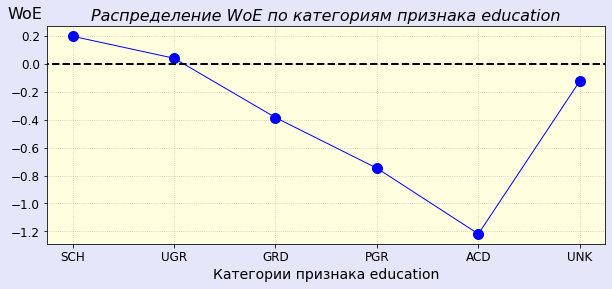

In [9]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Видим, что "населённость" категорий PGR, ACD и UNK не удовлетворяет эмпирическому правилу: доля наблюдений в каждой категории должна быть не меньше 5%. А что будет, если разделить на train и test? Возможны аномалии с очень малыми величинами в категориях.  
Поступим просто - объединим категории GRD, PGR, ACD и UNK (т.е. категории 2, 3, 4 и 5). Это не изменит "отрицательный" тип этих категорий - в смысле знака WoE.

In [10]:
#------------------------------------------------------------------------------#
data['education'] = data['education'].apply(lambda x: 2 if x > 2 else x)
data.education.value_counts().sort_index()

0    57998
1    14748
2    37402
Name: education, dtype: int64

,education_0,education_1,education_2
count_class_P,5852.000000,1291.000000,2229.000000
count_class_N,33008.000000,8525.000000,22894.000000
count_total,38860.000000,9816.000000,25123.000000
"fraction, %",52.700000,13.300000,34.000000
WoE,0.197840,0.040220,-0.401516
IV,0.022174,0.000218,0.047183


,education
IV,0.07


{'education': ['education_0', 'education_1', 'education_2']}


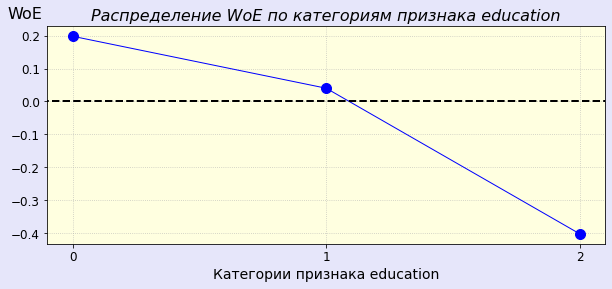

In [11]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

В принципе, наблюдаем ту же тенденцию, что и в исходном наборе данных: чем выше уровень образования, тем больше надёжность заёмщика. Величина WoE для бакалавров (категория UGR = категория 1) близка к нулю. Этот уровень образования можно принять за некий базовый уровень, в котором доля неплательщиков среди всех неплательщиков примерно совпадает с долей надёжных заёмщиков (среди всех клиентов класса 0, "Не-Дефолт"), т.е. условные вероятности почти совпадают: $p(education = UGR\,|\,y = 1) \approx p(education = UGR\,|\,y = 0)$, и, следовательно, $\text{WoE} = \ln \left( \frac{p(education = UGR\,|\,y = 1)}{p(education = UGR\,|\,y = 0)} \right) \approx 0$.

Также следует отметить, что интегральная величина IV практически не изменилась: было 0.073, стало 0.07. Судя по этим величинам, признак education обладает низкой прогностической способностью: IV = 0.07 < 0.1.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [12]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data.education = data.education.map(dct)

Запоминаем информацию по Woe и IV для признака.

In [13]:
#------------------------------------------------------------------------------#
df_local_WoE_IV = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV

,WoE,IV
education_0,0.197840,0.022174
education_1,0.040220,0.000218
education_2,-0.401516,0.047183


Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.908     0.357     0.512     12886
      Дефолт      0.145     0.751     0.243      1874

    accuracy                          0.407     14760
   macro avg      0.526     0.554     0.378     14760
weighted avg      0.811     0.407     0.478     14760


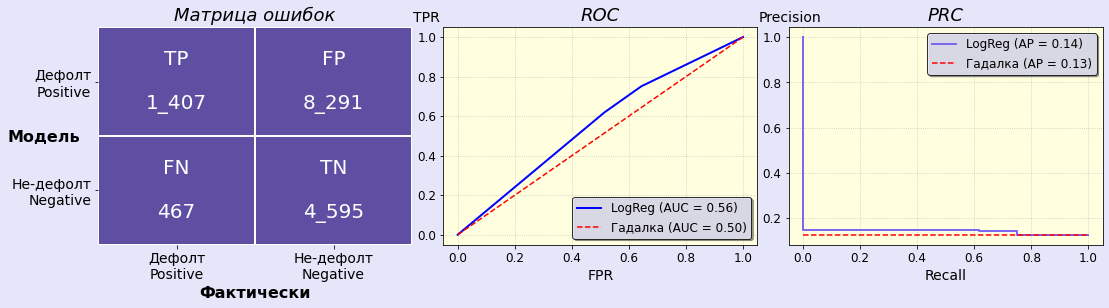

In [14]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [15]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = round(clf_report['macro avg']['f1-score'], 3)
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = round(roc_auc_score(conf_table[2], y_pred_proba[:,1]), 3)
df_features_rating = df_IV.append(
    df_(f1_macro, columns=[col], index=['f1_macro'])).append(
    df_(mcc, columns=[col], index=['MCC'])).append(
    df_(AUC_ROC, columns=[col], index=['AUC']))
np.round(df_features_rating, 3)

,education
IV,0.070
f1_macro,0.378
MCC,0.075
AUC,0.560


### 3.2. Признак `sex`.

In [16]:
#------------------------------------------------------------------------------#
col = 'sex'
cat_order = ['F', 'M']
data[col].value_counts().loc[cat_order]

F    61836
M    48312
Name: sex, dtype: int64

Преобразуем метки категорий в натуральные числа (в принципе, можно было бы пропустить этот этап).

In [17]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    61836
1    48312
Name: sex, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,sex_0,sex_1
count_class_P,5039.000000,4333.000000
count_class_N,36523.000000,27904.000000
count_total,41562.000000,32237.000000
"fraction, %",56.300000,43.700000
WoE,-0.052928,0.065296
IV,0.001547,0.001908


,sex
IV,0.003


{'sex': ['F', 'M']}


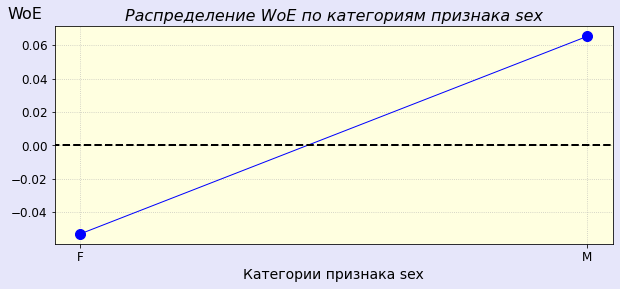

In [18]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Очень низкие значения WoE и IV: пол заёмщика почти не влияет на вероятность дефолта по кредиту.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [19]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [20]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.881     0.569     0.691     12886
      Дефолт      0.138     0.473     0.213      1874

    accuracy                          0.557     14760
   macro avg      0.509     0.521     0.452     14760
weighted avg      0.787     0.557     0.631     14760


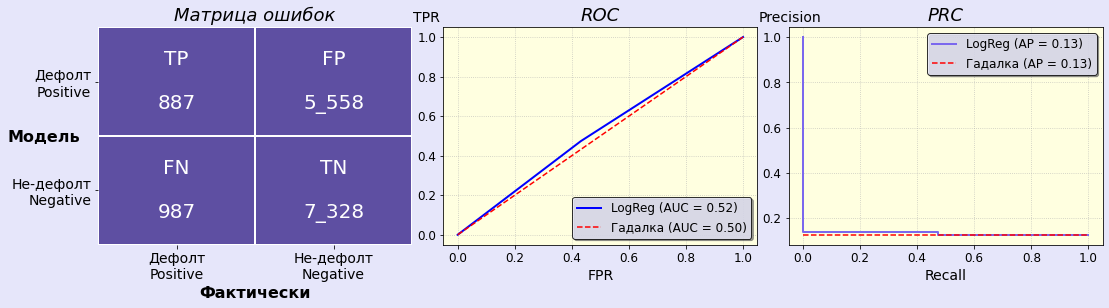

In [21]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [22]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = round(clf_report['macro avg']['f1-score'], 3)
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = round(roc_auc_score(conf_table[2], y_pred_proba[:,1]), 3)
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex
IV,0.070,0.003
f1_macro,0.378,0.452
MCC,0.075,0.028
AUC,0.560,0.521


### 3.3. Признаки `car` и `car_type`.
Конструируем из двух признаков - один.

In [23]:
#------------------------------------------------------------------------------#
cat_order = {'N': 0, 'Y': 1}
data.car = data.car.replace(to_replace=cat_order) + data.car_type.replace(
                                                    to_replace=cat_order)
# Удалаяем признак car_type:
data.drop(columns=['car_type'], inplace=True)
#---
data.car.value_counts().sort_index()

0    74290
1    14850
2    21008
Name: car, dtype: int64

Соответствие: 0 - нет автомобиля, 1 - отечественный автомобиль, 2 - "иномарка".

In [24]:
#------------------------------------------------------------------------------#
col = 'car'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

0    74290
1    14850
2    21008
Name: car, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,car_0,car_1,car_2
count_class_P,6825.000000,1322.000000,1225.000000
count_class_N,43007.000000,8637.000000,12783.000000
count_total,49832.000000,9959.000000,14008.000000
"fraction, %",67.500000,13.500000,19.000000
WoE,0.087036,0.050897,-0.417369
IV,0.005283,0.000356,0.028257


,car
IV,0.034


{'car': [0, 1, 2]}


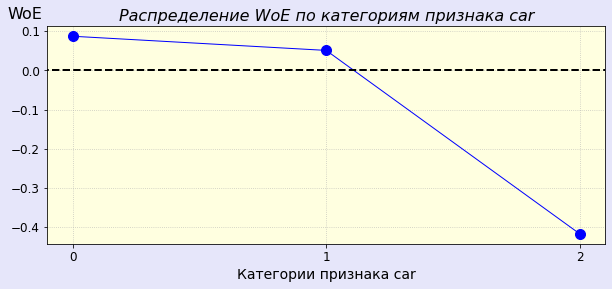

In [25]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Владельцы иномарок - более ответственные заёмщики. Судя по IV, признак car имеет низкую прогностическую способность: IV = 0.034 < 0.1.  
Объединим категории 0 и 1 и пересчитаем WoE.

In [26]:
#------------------------------------------------------------------------------#
data[col] = data[col].apply(lambda x: 0 if x == 1 else x)
data[col] = data[col].apply(lambda x: 1 if x == 2 else x)
data[col].value_counts().sort_index()

0    89140
1    21008
Name: car, dtype: int64

,car_0,car_1
count_class_P,8147.000000,1225.000000
count_class_N,51644.000000,12783.000000
count_total,59791.000000,14008.000000
"fraction, %",81.000000,19.000000
WoE,0.081082,-0.417369
IV,0.005489,0.028257


,car
IV,0.034


{'car': ['car_0', 'car_1']}


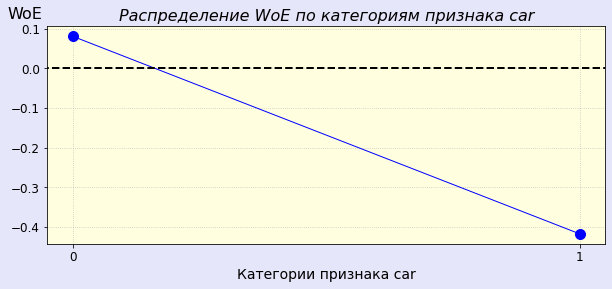

In [27]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [28]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [29]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.922     0.198     0.325     12886
      Дефолт      0.138     0.885     0.239      1874

    accuracy                          0.285     14760
   macro avg      0.530     0.541     0.282     14760
weighted avg      0.822     0.285     0.314     14760


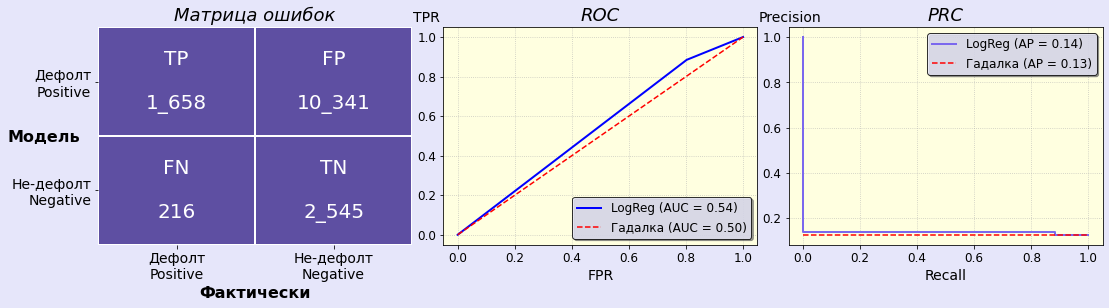

In [30]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [31]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = round(clf_report['macro avg']['f1-score'], 3)
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = round(roc_auc_score(conf_table[2], y_pred_proba[:,1]), 3)
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car
IV,0.070,0.003,0.034
f1_macro,0.378,0.452,0.282
MCC,0.075,0.028,0.070
AUC,0.560,0.521,0.541


### 3.4. Признак `good_work`.

In [32]:
col = 'good_work'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

0    91917
1    18231
Name: good_work, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,good_work_0,good_work_1
count_class_P,8222.000000,1150.000000
count_class_N,53408.000000,11019.000000
count_total,61630.000000,12169.000000
"fraction, %",83.500000,16.500000
WoE,0.056659,-0.332053
IV,0.002738,0.016046


,good_work
IV,0.019


{'good_work': [0, 1]}


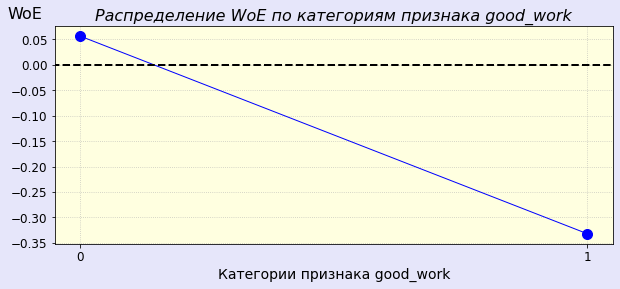

In [33]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Судя по величине интегрального IV, признак good_work почти бесполезен: IV < 0.02.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [34]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [35]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.900     0.169     0.285     12886
      Дефолт      0.132     0.870     0.230      1874

    accuracy                          0.258     14760
   macro avg      0.516     0.520     0.257     14760
weighted avg      0.802     0.258     0.278     14760


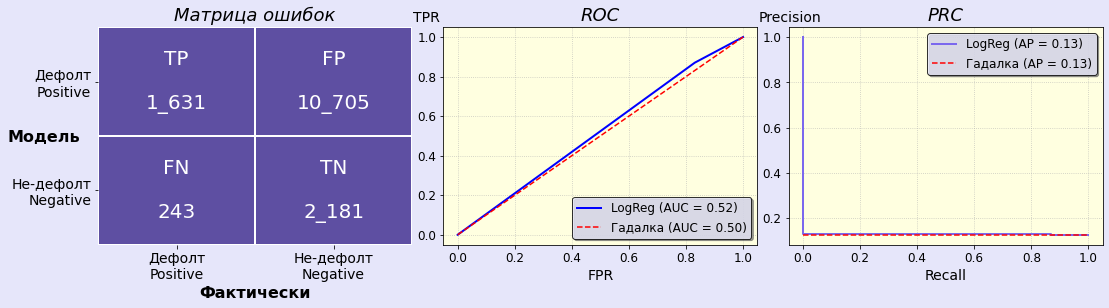

In [36]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [37]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = round(clf_report['macro avg']['f1-score'], 3)
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = round(roc_auc_score(conf_table[2], y_pred_proba[:,1]), 3)
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work
IV,0.070,0.003,0.034,0.019
f1_macro,0.378,0.452,0.282,0.257
MCC,0.075,0.028,0.070,0.036
AUC,0.560,0.521,0.541,0.520


### 3.5. Признак `region_rating`.

In [38]:
col = 'region_rating'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

20      313
30      434
40    17947
50    40981
60    23999
70     9304
80    17170
Name: region_rating, dtype: int64

In [39]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0      313
1      434
2    17947
3    40981
4    23999
5     9304
6    17170
Name: region_rating, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6
count_class_P,44.000000,57.000000,2041.000000,3747.000000,2071.000000,573.000000,839.000000
count_class_N,162.000000,243.000000,9986.000000,23776.000000,14004.000000,5626.000000,10630.000000
count_total,206.000000,300.000000,12027.000000,27523.000000,16075.000000,6199.000000,11469.000000
"fraction, %",0.300000,0.400000,16.300000,37.300000,21.800000,8.400000,15.500000
WoE,0.624400,0.477796,0.340062,0.080085,0.016495,-0.356462,-0.611418
IV,0.001361,0.001104,0.021349,0.002464,0.000060,0.009334,0.046144


,region_rating
IV,0.082


{'region_rating': [20, 30, 40, 50, 60, 70, 80]}


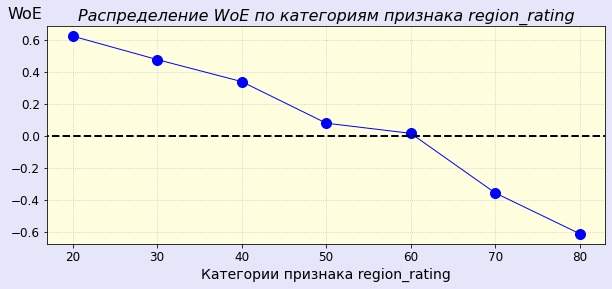

In [40]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Признак region_rating обладает небольшой прогностической способностью: IV = 0.082 < 0.1.  
Что видим:
* первые две категории 20 (region_rating_0) и 30 (region_rating_1) слабо заселены: меньше 5%. Объединим их с третьей категорией.
* категории 50 (region_rating_3) и 60 (region_rating_4) имеют близкие значения WoE, объединим эти две категории в одну.

In [41]:
#------------------------------------------------------------------------------#
data[col] = data[col].replace([0, 1, 2], 0)
data[col] = data[col].replace([3, 4], 1)
data[col] = data[col].replace([5, 6], [2, 3])
data[col].value_counts().sort_index()

0    18694
1    64980
2     9304
3    17170
Name: region_rating, dtype: int64

,region_rating_0,region_rating_1,region_rating_2,region_rating_3
count_class_P,2142.000000,5818.000000,573.000000,839.000000
count_class_N,10391.000000,37780.000000,5626.000000,10630.000000
count_total,12533.000000,43598.000000,6199.000000,11469.000000
"fraction, %",17.000000,59.100000,8.400000,15.500000
WoE,0.348606,0.056983,-0.356462,-0.611418
IV,0.023451,0.001959,0.009334,0.046144


,region_rating
IV,0.081


{'region_rating': ['region_rating_0', 'region_rating_1', 'region_rating_2', 'region_rating_3']}


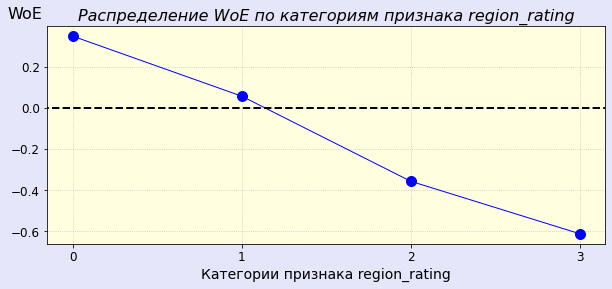

In [42]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [43]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [44]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.919     0.254     0.398     12886
      Дефолт      0.142     0.846     0.242      1874

    accuracy                          0.329     14760
   macro avg      0.530     0.550     0.320     14760
weighted avg      0.820     0.329     0.378     14760


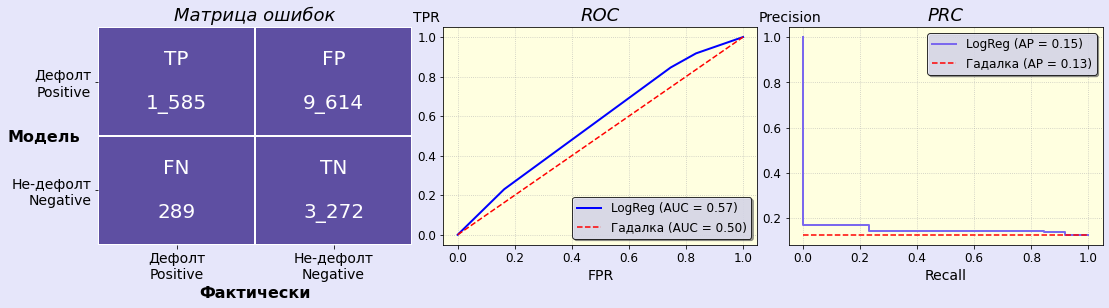

In [45]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [46]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = round(matthews_corrcoef(conf_table[2], conf_table[3]), 3)
AUC_ROC = round(roc_auc_score(conf_table[2], y_pred_proba[:,1]), 3)
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating
IV,0.070,0.003,0.034,0.019,0.081
f1_macro,0.378,0.452,0.282,0.257,0.320
MCC,0.075,0.028,0.070,0.036,0.078
AUC,0.560,0.521,0.541,0.520,0.569


### 3.6. Признак `home_address`.

In [47]:
col = 'home_address'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

1    48688
2    59591
3     1869
Name: home_address, dtype: int64

In [48]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    48688
1    59591
2     1869
Name: home_address, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,home_address_0,home_address_1,home_address_2
count_class_P,3027.000000,6199.000000,146.000000
count_class_N,29558.000000,33757.000000,1112.000000
count_total,32585.000000,39956.000000,1258.000000
"fraction, %",44.200000,54.100000,1.700000
WoE,-0.350976,0.233006,-0.102503
IV,0.047662,0.032034,0.000172


,home_address
IV,0.08


{'home_address': [1, 2, 3]}


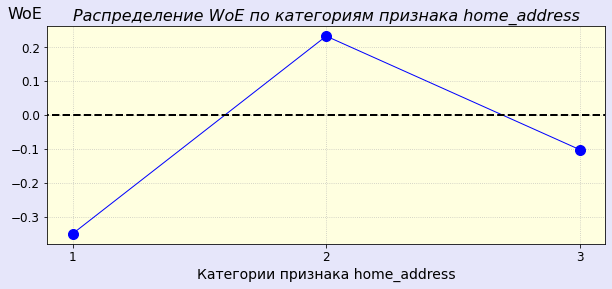

In [49]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Судя по IV, признак home_address обладает низкой прогностической способностью: IV = 0.08 < 0.1.  
Населённость третьей категории меньше 5%, объединим её с... нет, не с категорией 2, а с категорией 1, т.к. знак WoE один и тот же у первой и третьей категорий.

In [50]:
#------------------------------------------------------------------------------#
data[col] = data[col].replace([0, 2], 0)
data[col].value_counts().sort_index()

0    50557
1    59591
Name: home_address, dtype: int64

,home_address_0,home_address_1
count_class_P,3173.000000,6199.000000
count_class_N,30670.000000,33757.000000
count_total,33843.000000,39956.000000
"fraction, %",45.900000,54.100000
WoE,-0.340801,0.233006
IV,0.046854,0.032034


,home_address
IV,0.079


{'home_address': ['home_address_0', 'home_address_1']}


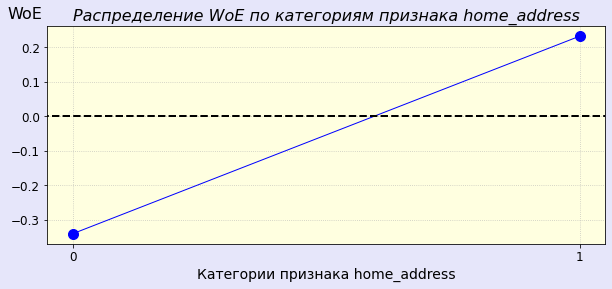

In [51]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [52]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [53]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.908     0.471     0.620     12886
      Дефолт      0.156     0.670     0.252      1874

    accuracy                          0.496     14760
   macro avg      0.532     0.570     0.436     14760
weighted avg      0.812     0.496     0.574     14760


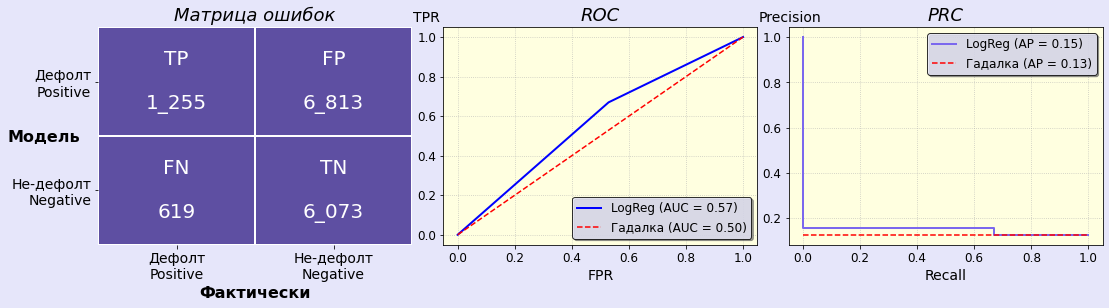

In [54]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [55]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address
IV,0.070,0.003,0.034,0.019,0.081,0.079
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436
MCC,0.075,0.028,0.070,0.036,0.078,0.094
AUC,0.560,0.521,0.541,0.520,0.569,0.570


### 3.7. Признак `work_address`.

In [56]:
col = 'work_address'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

1    12274
2    30761
3    67113
Name: work_address, dtype: int64

In [57]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    12274
1    30761
2    67113
Name: work_address, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,work_address_0,work_address_1,work_address_2
count_class_P,618.000000,2102.000000,6652.000000
count_class_N,7716.000000,18404.000000,38307.000000
count_total,8334.000000,20506.000000,44959.000000
"fraction, %",11.300000,27.800000,60.900000
WoE,-0.596757,-0.241872,0.177091
IV,0.032119,0.014844,0.020400


,work_address
IV,0.067


{'work_address': [1, 2, 3]}


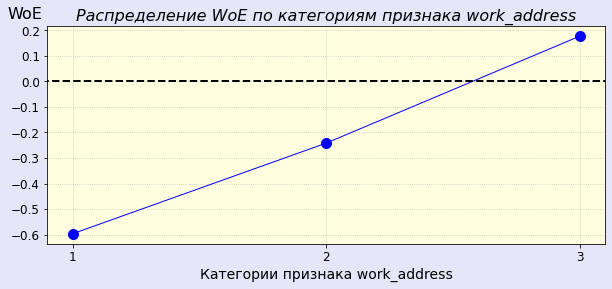

In [58]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Красивая, почти линейная, зависимость. Однако прогностическая способность признака work_address низкая: IV = 0.067 < 0.1.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [59]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.596757    12274
-0.241872    30761
 0.177091    67113
Name: work_address, dtype: int64

Запоминаем информацию по WoE и IV для признака.

In [60]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.908     0.399     0.554     12886
      Дефолт      0.149     0.723     0.247      1874

    accuracy                          0.440     14760
   macro avg      0.528     0.561     0.401     14760
weighted avg      0.812     0.440     0.515     14760


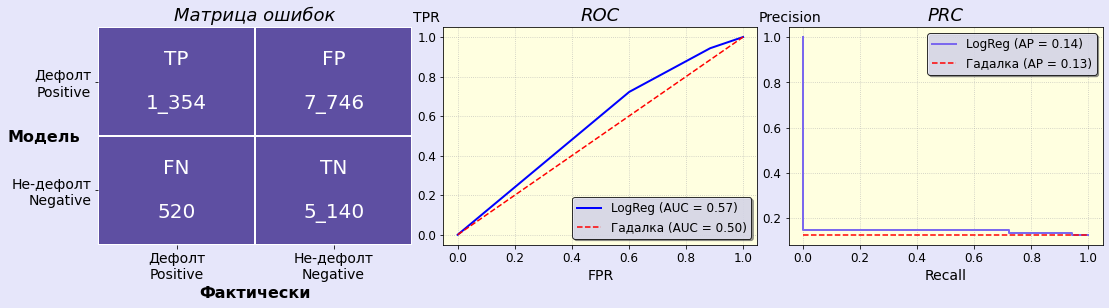

In [61]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [62]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565


### 3.8. Признак `sna`.

In [63]:
col = 'sna'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

1    70681
2    15832
3     6154
4    17481
Name: sna, dtype: int64

In [64]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    70681
1    15832
2     6154
3    17481
Name: sna, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,sna_0,sna_1,sna_2,sna_3
count_class_P,4645.000000,1592.000000,650.000000,2485.000000
count_class_N,42656.000000,9034.000000,3473.000000,9264.000000
count_total,47301.000000,10626.000000,4123.000000,11749.000000
"fraction, %",64.100000,14.400000,5.600000,15.900000
WoE,-0.289570,0.191802,0.252005,0.611943
IV,0.048201,0.005686,0.003893,0.074266


,sna
IV,0.132


{'sna': [1, 2, 3, 4]}


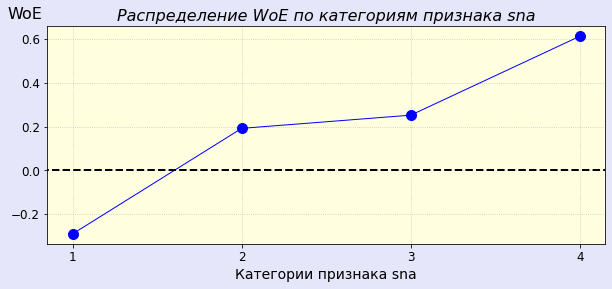

In [65]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Признак sna - первый признак, прогностическая сила которого находится на среднем уровне: IV = 0.132 > 0.1.  
Величины WoE для второй и третьей категорий близки - объединим их в одну категорию.

In [66]:
#------------------------------------------------------------------------------#
data[col] = data[col].replace([1, 2], 1)
data[col] = data[col].replace(3, 2)
data[col].value_counts().sort_index()

0    70681
1    21986
2    17481
Name: sna, dtype: int64

,sna_0,sna_1,sna_2
count_class_P,4645.000000,2242.000000,2485.000000
count_class_N,42656.000000,12507.000000,9264.000000
count_total,47301.000000,14749.000000,11749.000000
"fraction, %",64.100000,20.000000,15.900000
WoE,-0.289570,0.208886,0.611943
IV,0.048201,0.009420,0.074266


,sna
IV,0.132


{'sna': ['sna_0', 'sna_1', 'sna_2']}


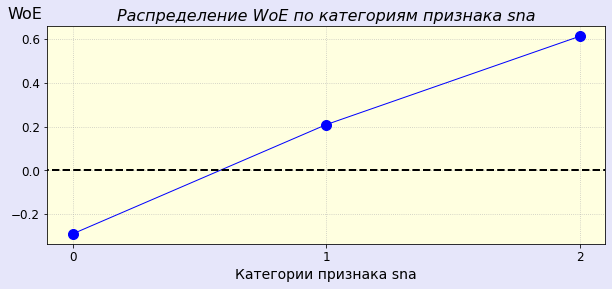

In [67]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [68]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.289570    70681
 0.208886    21986
 0.611943    17481
Name: sna, dtype: int64

Запоминаем информацию по WoE и IV для признака.

In [69]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.903     0.666     0.767     12886
      Дефолт      0.181     0.506     0.266      1874

    accuracy                          0.646     14760
   macro avg      0.542     0.586     0.516     14760
weighted avg      0.811     0.646     0.703     14760


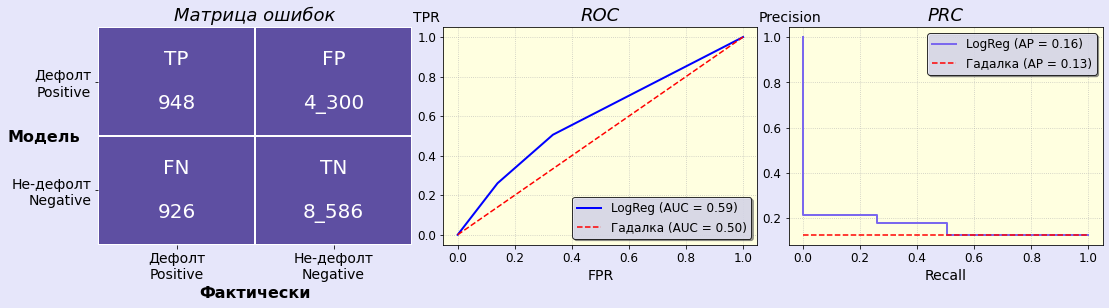

In [70]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [71]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594


### 3.9. Признак `first_time`.

In [72]:
col = 'first_time'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

1    18296
2    17247
3    46588
4    28017
Name: first_time, dtype: int64

In [73]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    18296
1    17247
2    46588
3    28017
Name: first_time, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,first_time_0,first_time_1,first_time_2,first_time_3
count_class_P,2278.000000,1798.000000,3759.000000,1537.000000
count_class_N,9961.000000,9770.000000,27496.000000,17200.000000
count_total,12239.000000,11568.000000,31255.000000,18737.000000
"fraction, %",16.600000,15.700000,42.400000,25.400000
WoE,0.452427,0.235165,-0.062081,-0.487271
IV,0.040020,0.009454,0.001595,0.050174


,first_time
IV,0.101


{'first_time': [1, 2, 3, 4]}


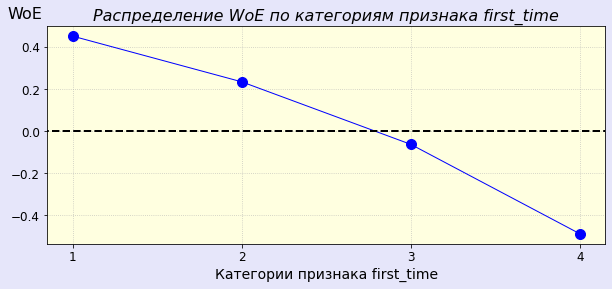

In [74]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Признак first_time - второй признак с силой прогноза на среднем уровне: IV = 0.101 > 0.1.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [75]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.487271    28017
-0.062081    46588
 0.235165    17247
 0.452427    18296
Name: first_time, dtype: int64

Запоминаем информацию по WoE и IV для признака.

In [76]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.895     0.694     0.782     12886
      Дефолт      0.173     0.440     0.249      1874

    accuracy                          0.662     14760
   macro avg      0.534     0.567     0.515     14760
weighted avg      0.803     0.662     0.714     14760


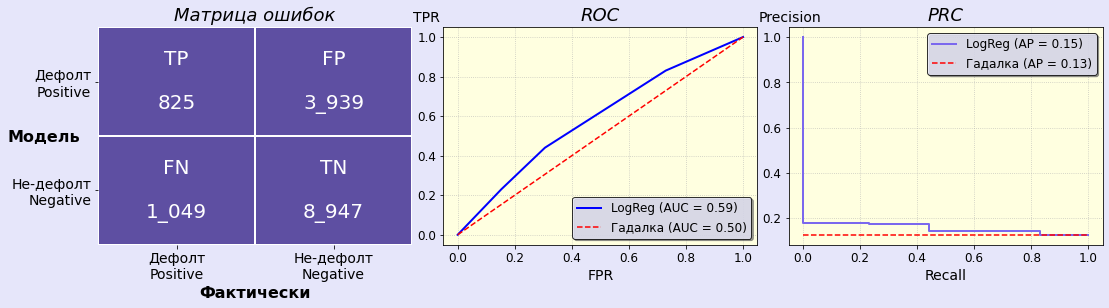

In [77]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [78]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586


### 3.10. Признак `foreign_passport`.

In [79]:
col = 'foreign_passport'
cat_order = sorted(data[col].unique().tolist())
data[col].value_counts().loc[cat_order]

N    93721
Y    16427
Name: foreign_passport, dtype: int64

In [80]:
#------------------------------------------------------------------------------#
corresp_dct = {val: k for k, val in enumerate(cat_order)}
data[col] = data[col].map(corresp_dct)
data[col].value_counts().sort_index()

0    93721
1    16427
Name: foreign_passport, dtype: int64

Считаем WoE и IV для категорий признака и интегральный IV для всего признака.

,foreign_passport_0,foreign_passport_1
count_class_P,8552.000000,820.000000
count_class_N,54181.000000,10246.000000
count_total,62733.000000,11066.000000
"fraction, %",85.000000,15.000000
WoE,0.081641,-0.597532
IV,0.005840,0.042746


,foreign_passport
IV,0.049


{'foreign_passport': ['N', 'Y']}


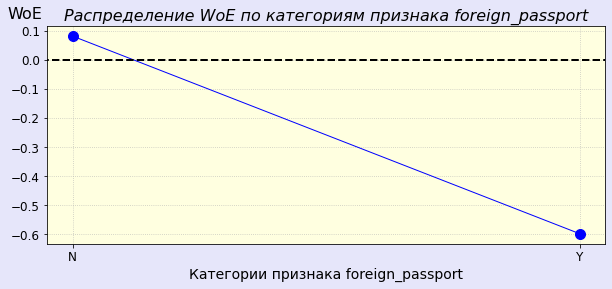

In [81]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

У признака foreign_passport низкая прогностическая способность: IV = 0.049 < 0.1.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [82]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.597532    16427
 0.081641    93721
Name: foreign_passport, dtype: int64

Запоминаем информацию по WoE и IV для признака.

In [83]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.921     0.163     0.277     12886
      Дефолт      0.136     0.904     0.236      1874

    accuracy                          0.257     14760
   macro avg      0.529     0.534     0.256     14760
weighted avg      0.822     0.257     0.272     14760


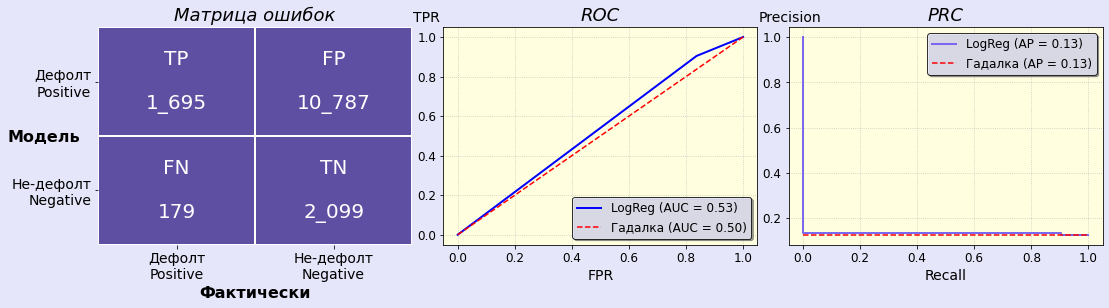

In [84]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [85]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534


#### Взглянем на корреляцию интегральных величин в таблице df_features_rating.

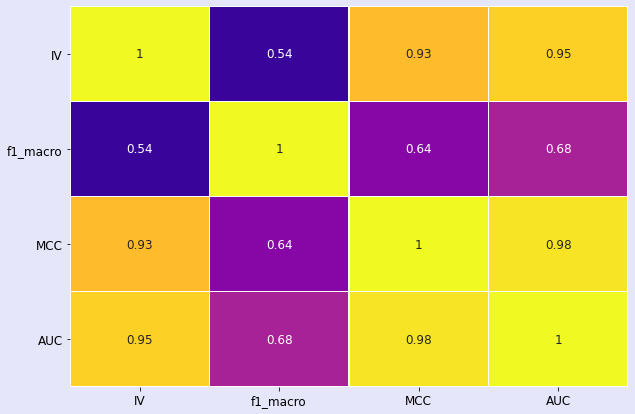

In [86]:
#------------------------------------------------------------------------------#
df = df_features_rating.T.copy()
annot_kws = {'fontsize': 12}
sns.heatmap(df.corr(method='spearman'), vmin=0.5, vmax=1, annot = True, 
            cmap='plasma', linewidths=.5, annot_kws=annot_kws, cbar=False)
plt.gcf().set_size_inches(10, 7);

Наиболее сильные корреляции наблюдаются между AUC ROC, коэффициентом Мэтьюса и Information Value. Метрика f1_macro практически гуляет сама по себе.  
Взглянем на графики:

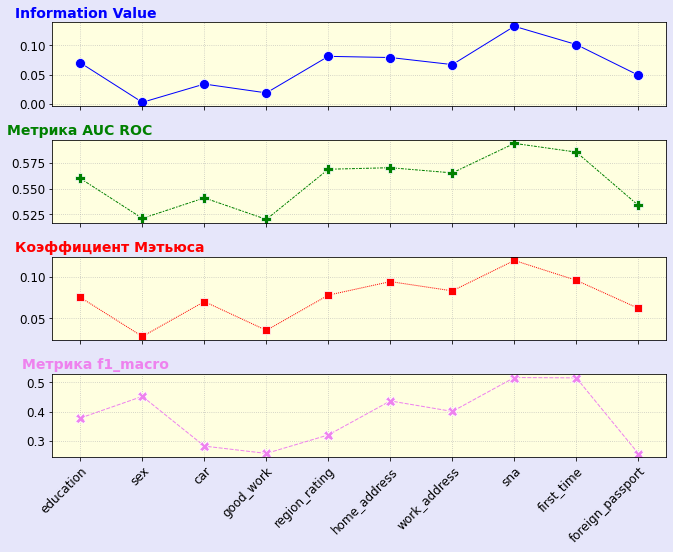

In [87]:
#------------------------------------------------------------------------------#
df = df_features_rating.T.copy()
fig, ax = plt.subplots(4, 1, figsize=(11, 8), sharex=True)
fig.subplots_adjust(hspace=0.4)
sns.lineplot(data=df, hue_order=['IV'], ax=ax[0], legend=False, markers=True,
             ms=10, lw=1, palette=['b']);
sns.lineplot(data=df, hue_order=['AUC'], ax=ax[1], legend=False, markers=True,
             ms=10, lw=1, palette=['g']);
sns.lineplot(data=df, hue_order=['MCC'], ax=ax[2], legend=False, markers=True,
             ms=10, lw=1, palette=['r']);
sns.lineplot(data=df, hue_order=['f1_macro'], ax=ax[3], legend=False, markers=True,
             ms=10, lw=1, palette=['violet']);
plt.setp(ax[3].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
ax[0].set_ylabel('Information Value', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='blue')
ax[1].set_ylabel('Метрика AUC ROC', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='green');
ax[2].set_ylabel('Коэффициент Мэтьюса', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='red');
ax[3].set_ylabel('Метрика f1_macro', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='violet');

Ясно виден схожий характер изменения метрик IV, AUC ROC и MCC.

Взглянем на таблицу df_local_WoE_IV, в которой каждой категории соответстуют её локальные значения WoE и IV.

In [88]:
# Упорядочим по убыванию IV:
df_local_WoE_IV.sort_values(by='IV', ascending=False)

,WoE,IV
sna_2,0.611943,0.074266
first_time_3,-0.487271,0.050174
sna_0,-0.289570,0.048201
education_2,-0.401516,0.047183
home_address_0,-0.340801,0.046854
region_rating_3,-0.611418,0.046144
foreign_passport_1,-0.597532,0.042746
first_time_0,0.452427,0.040020
work_address_0,-0.596757,0.032119
home_address_1,0.233006,0.032034


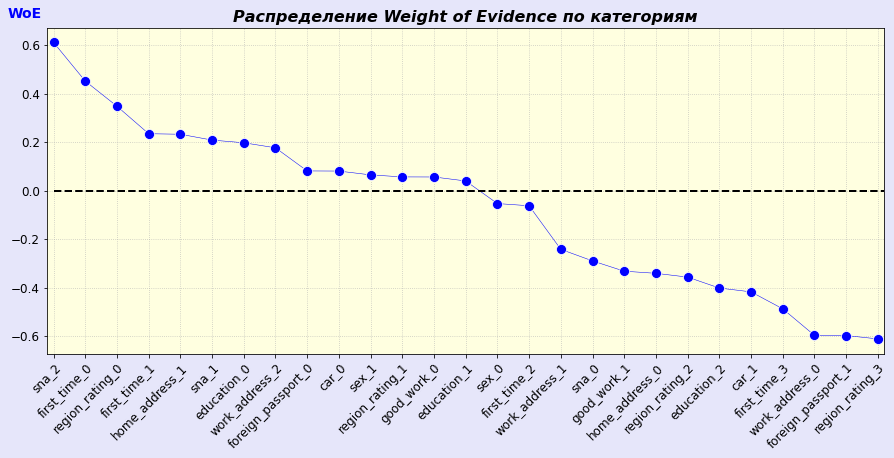

In [89]:
#------------------------------------------------------------------------------#
df = df_local_WoE_IV.copy()
df = df.sort_values(by='WoE', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.lineplot(data=df, hue_order=['WoE'], legend=False, markers=True, ms=10,
             lw=0.5, palette=['b']);
ax.set_ylabel('WoE', rotation=0, position=(0, 1.02), ha='left',
              fontweight='bold', color='blue');
# Линия нуля:
ax.plot([0, df.shape[0]], [0, 0], lw=2, c='k', ls='--');
#---
ax.xaxis.set_view_interval(-0.2, 26.2, ignore=True);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");
ax.set_title('Распределение Weight of Evidence по категориям',
             style='italic', fontweight='bold');

График иллюстрирует тот факт, что WoE является удобной величиной для анализа данных: сразу видно, какие именно категории признаков благоприятствуют дефолту у заёмщика (WoE > 0) и, наоборот, какие категории свидетельствуют о малом риске дефолта (WoE < 0).

#### Посмотрим, как работает модель для категориальных признаков - после того, как осуществлена процедура WoE-преобразования (т.е. значения категорий заменены их WoE величинами).

(59039, 10) (14760, 10)
              precision    recall  f1-score   support

   Не-дефолт      0.921     0.624     0.744     12886
      Дефолт      0.197     0.634     0.301      1874

    accuracy                          0.625     14760
   macro avg      0.559     0.629     0.522     14760
weighted avg      0.830     0.625     0.688     14760

Коэффициент Мэтьюса:  0.175


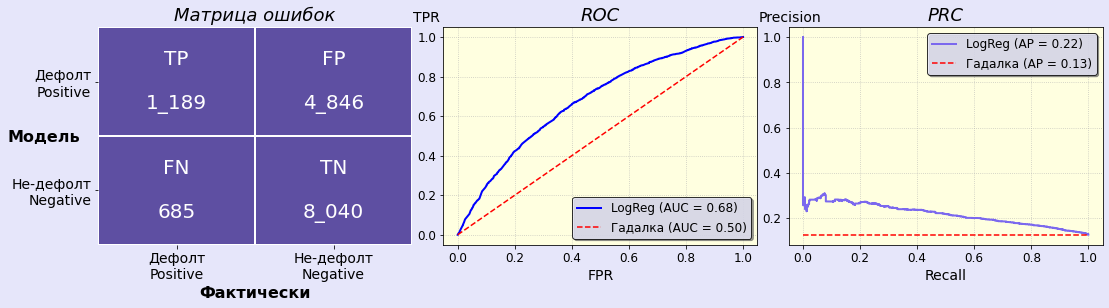

In [90]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][cat_feats].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)
MCC = matthews_corrcoef(y_test, lr.predict(X_test))
print(f"\nКоэффициент Мэтьюса: {MCC: .3f}")

Видим, что коллективная модель работает существенно лучше по сравнению с индивидуальными моделями, которые задействуют только один признак. Впрочем, это - вполне ожидаемый результат.

Посмотрим на коэффициенты логистической регрессии.

intercept = 0.004 



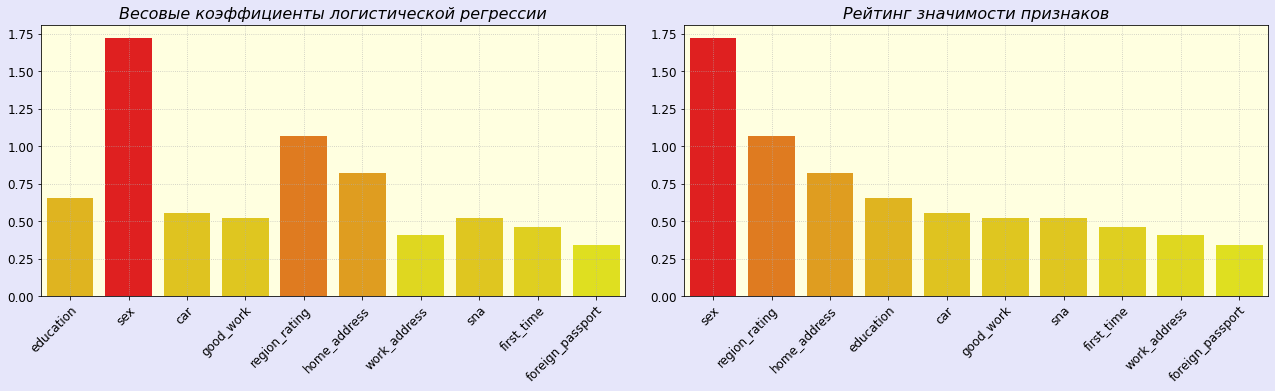

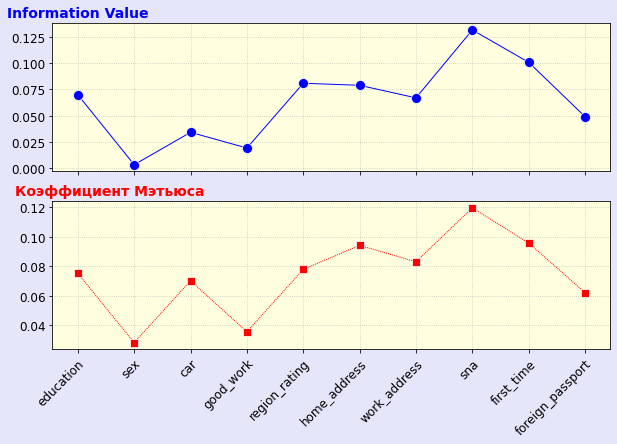

In [91]:
#------------------------------------------------------------------------------#
print(f'intercept = {lr.intercept_[0]:.3f}', '\n')
feature_importance_on_log_reg_coef(*coef_vals)
#---
df = df_features_rating.T.copy()
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.subplots_adjust(hspace=0.2)
sns.lineplot(data=df, hue_order=['IV'], ax=ax[0], legend=False, markers=True,
             ms=10, lw=1, palette=['b']);
sns.lineplot(data=df, hue_order=['MCC'], ax=ax[1], legend=False, markers=True,
             ms=10, lw=1, palette=['r']);
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
ax[0].set_ylabel('Information Value', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='blue')
ax[1].set_ylabel('Коэффициент Мэтьюса', rotation=0, position=(0, 1.02),
                 ha='left', fontweight='bold', color='red');

#### На первый взгляд, имеет место весьма странная картина:
>1. Признак `sex`, имея наименьшую прогностическую способность (IV < 0.02), получил максимальный весовой коэффициент логистической регрессии. В то же время признак `sna`, обладая наибольшей (среди всех категориальных признаков) прогностической силой (IV > 0.1), плетётся ближе к концу по величине весового коэффициента.
>2. Все весовые коэффициенты логистической регрессии положительны.

Также обратим внимание на то, что свободный член логистической регрессии (intercept) практически нулевой.

***
Дело в том, что после преобразования категорий к их WoE-значениям и использования логистической регрессии весовые коэффициенты приобретают несколько иной смысл. В самом деле, "традиционное" использование логистической регрессии подразумевает, что функция log-odds вычисляется в виде линейной комбинации признаков. Следовательно, коэффициенты этой комбинации вполне законно рассматривать как вклад того или иного признака в итоговое значение log-odds.

После осуществления процедуры WoE-преобразования мы получаем уже не признаки, а их WoE-отображения, или WoE-представления. Это означает, что log-odds теперь выражается уже НЕ через линейную комбинацию _признаков_, а через сумму WoE-величин. Строго говоря, в этой сумме наличие коэффициентов не обязательно. Точнее, они все могут быть равны единице:
$$
\text{log-odds} = \text{intercept} + \sum_{k = 1}^n{WoE_k},\,\,\,\,\text{intercept} = \ln{\frac{p(y = 1)}{p(y = 0)}}, \,\,\,\,(1) 
$$
где $n$ - количество признаков.  
Формула (1) - это наивный байесовский классификатор (НБК). Весь процесс обучения такого НБК сводится "всего лишь" к вычислению WoE для категорий признаков, т.е. используется та выборка (обучающая выборка) по клиентам, для которой известны метки класса ("Дефолт", "Не-Дефолт"). После этого вероятность того, что новый клиент относится к классу "Дефолт" (или "Не-Дефолт"), вычисляется следующим образом. Признаки, идентифицирующие этого клиента, распределяются по уже известным (из процесса обучения) категориям с известными WoE-величинами, и применяется формула (1).

Давайте-ка посмотрим, как работает наивный байесовский классификатор (1). Используем вычисленное выше разбиение выборки на train, test. Величины WoE уже известны, intercept как натуральный логарифм отношения априорных вероятностей классов вычисляется элементарно. Для $i$-го клиента из тестовой выборки вычисляем log-odds по формуле (1), а затем определяем искомую условную вероятность наблюдения класса 1 ("Дефолт") на данном клиенте:
$$
p(y = 1\,|\,\vec x_i) = \sigma \left( \text{log-odds}_i \right) = \left(1 + e^{-\text{log-odds}_i}\right)^{-1}.
$$
**_Важный момент_**. Как мы знаем, наш набор данных имеет дисбаланс классов. Для учёта этого момента будем использовать для НБК так называемую величину отсечки ("порог бинаризации") cut_off по вероятности принадлежности к классу 1 ("Дефолт"). Конкретное значение cut_off определяется в цикле как такое значение, которое доставляет максимум коэффициенту корреляции Мэтьюса. При этом процесс отыскания cut_off осуществляется на _обучающей_ выборке.

Обратный дисбаланс классов на обучающей выборке:
	D = count('Дефолт') / count('Не-Дефолт') = 0.145
Intercept = ln(D) = -1.928

НАИВНЫЙ Байесовский классификатор (НБК):
Коэффициент Мэтьюса = 0.168
Порог бинаризации = 0.135

ПОЛУ-НАИВНЫЙ Байесовский классификатор (ПОЛУ-НБК):
Intercept = 0.004
Коэффициент Мэтьюса:  0.175


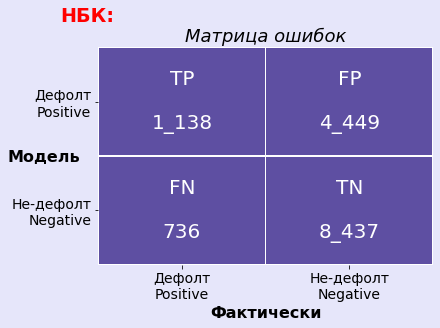

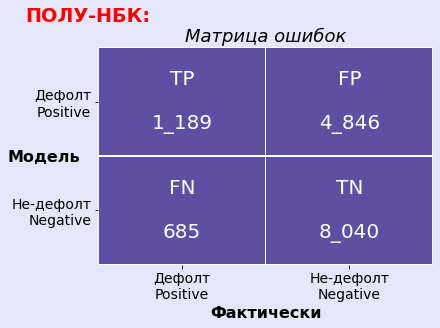

In [92]:
#------------------------------------------------------------------------------#
df = X_train.copy()
ds = y_train.value_counts().sort_index()
df['intercept'] = np.log(ds.loc[1] / ds.loc[0])
print("Обратный дисбаланс классов на обучающей выборке:")
print(f"\tD = count('Дефолт') / count('Не-Дефолт') = {ds.loc[1]/ds.loc[0]:.3f}")
print(f"Intercept = ln(D) = {np.log(ds.loc[1] / ds.loc[0]):.3f}\n")
log_odds = df.sum(axis=1)
y_pred_proba = 1 / (1 + np.exp(-log_odds))
# Определяем порог бинаризации по максимуму коэффициента Мэтьюса:
tresh = []
mcc_vals = []
MCC_max = -100
for cut_val in np.arange(0.001, 0.77, 0.001):
    y_predict = (y_pred_proba > cut_val).astype(int)
    MCC = matthews_corrcoef(y_train, y_predict)
    tresh.append(cut_val)
    mcc_vals.append(MCC)
    if MCC_max <= MCC:
        MCC_max = MCC
        cut_off = cut_val
# "Предсказываем" классы для test:
df = X_test.copy()
ds = y_test.value_counts().sort_index()
df['intercept'] = np.log(ds.loc[1] / ds.loc[0])
log_odds = df.sum(axis=1)
y_pred_proba = 1 / (1 + np.exp(-log_odds))
y_predict = (y_pred_proba > cut_off).astype(int)
# НАИВНЫЙ Байесовский классификатор (НБК):
print("НАИВНЫЙ Байесовский классификатор (НБК):")
print(f"Коэффициент Мэтьюса = {MCC_max:.3f}")
print(f"Порог бинаризации = {cut_off:.3f}")
conf_table_NBC = (_, X_test, y_test, y_predict)
confusion_table_ROC_and_PRC(*conf_table_NBC, ocm=True)
fig0 = plt.gcf()
fig0.suptitle('НБК:', x=0.1, y=1.02, weight='bold', color='red')
# ПОЛУ-НАИВНЫЙ Байесовский классификатор (ПНБК):
print("\nПОЛУ-НАИВНЫЙ Байесовский классификатор (ПОЛУ-НБК):")
print(f'Intercept = {lr.intercept_[0]:.3f}')
MCC = matthews_corrcoef(y_test, lr.predict(X_test))
print(f"Коэффициент Мэтьюса: {MCC: .3f}")
confusion_table_ROC_and_PRC(*conf_table, ocm=True)
fig1 = plt.gcf()
fig1.suptitle('ПОЛУ-НБК:', x=0.1, y=1.02, weight='bold', color='red');

(0.135, 0.16792105189935064)

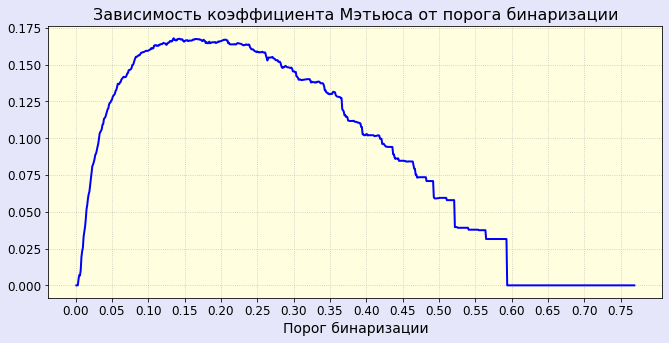

In [93]:
df_MCC = pd.DataFrame([tresh, mcc_vals]).T
df_MCC.columns = ['tresh', 'MCC']
idx = df_MCC.MCC.idxmax()
fig, ax = plt.subplots(figsize=(11,5))
plt.plot(df_MCC['tresh'], df_MCC['MCC'], lw=2, color='b');
ax.set_title('Зависимость коэффициента Мэтьюса от порога бинаризации')
ax.set_xlabel('Порог бинаризации')
ax.set_xticks(np.arange(0, 0.8, 0.05))
df_MCC.loc[idx, 'tresh'], df_MCC.loc[idx, 'MCC']

In [94]:
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
# НАИВНЫЙ Байесовский классификатор (НБК):
print('НБК:')
print('='*53)
print(classification_report(conf_table_NBC[2], conf_table_NBC[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)
# ПОЛУ-НАИВНЫЙ Байесовский классификатор (ПНБК):
print('\nПОЛУ-НБК:')
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

НБК:
              precision    recall  f1-score   support

   Не-дефолт      0.920     0.655     0.765     12886
      Дефолт      0.204     0.607     0.305      1874

    accuracy                          0.649     14760
   macro avg      0.562     0.631     0.535     14760
weighted avg      0.829     0.649     0.707     14760

ПОЛУ-НБК:
              precision    recall  f1-score   support

   Не-дефолт      0.921     0.624     0.744     12886
      Дефолт      0.197     0.634     0.301      1874

    accuracy                          0.625     14760
   macro avg      0.559     0.629     0.522     14760
weighted avg      0.830     0.625     0.688     14760


intercept = -1.924


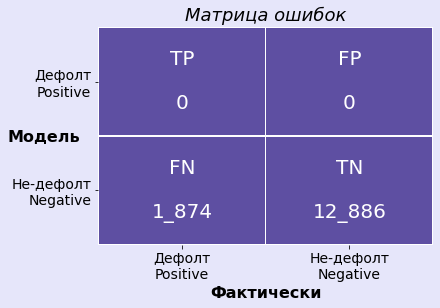

In [95]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][cat_feats].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
# Логистическая регрессия (БЕЗ УЧЁТА ДИСБАЛАНСА КЛАССОВ):
lr0 = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)#,
#                        class_weight='balanced')
lr0.fit(X_train, y_train)
y_pred = lr0.predict(X_test)
y_pred_proba = lr0.predict_proba(X_test)
conf_table = (lr0, X_test, y_test, y_pred)
confusion_table_ROC_and_PRC(*conf_table, ocm=True)
print(f'intercept = {lr0.intercept_[0]:.3f}')

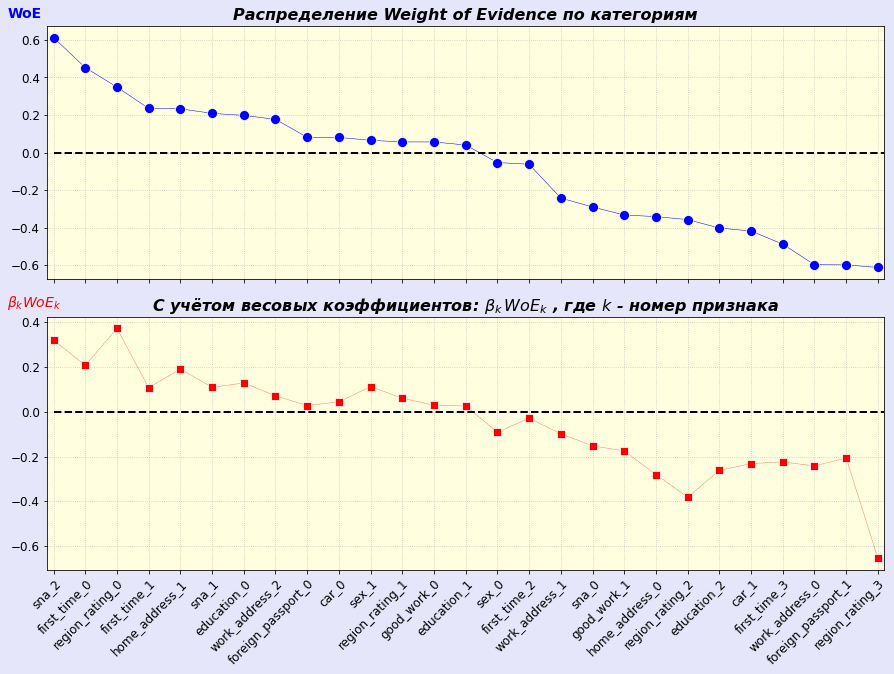

In [96]:
#------------------------------------------------------------------------------#
df = df_local_WoE_IV.copy()
dct = {val: lr.coef_[0][k] for k, val in enumerate(cat_feats)}
for val in cat_feats:
    for idx in df.index:
        if val in idx:
            df.loc[idx, 'WoE_betta'] = df.loc[idx, 'WoE'] * dct[val]
df = df.sort_values(by='WoE', ascending=False)
#---
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.subplots_adjust(hspace=0.15)
sns.lineplot(data=df, hue_order=['WoE'], legend=False, markers=True, ms=10,
             lw=0.5, palette=['b'], ax=ax[0]);
sns.lineplot(data=df, hue_order=['WoE_betta'], legend=False, markers=True,
             ms=10, lw=0.5, palette=['r'], ax=ax[1]);
ax[0].set_ylabel('WoE', rotation=0, position=(0, 1.02), ha='left',
              fontweight='bold', color='blue');
ax[1].set_ylabel(r'$\beta_k WoE_k$', rotation=0,
                 position=(0, 1.02), ha='left', fontweight='bold', color='red')
# Линия нуля:
ax[0].plot([0, df.shape[0]], [0, 0], lw=2, c='k', ls='--');
ax[1].plot([0, df.shape[0]], [0, 0], lw=2, c='k', ls='--');
#------------------------------------------------------------------------------#
ax[0].xaxis.set_view_interval(-0.2, 26.2, ignore=True);
ax[1].xaxis.set_view_interval(-0.2, 26.2, ignore=True);
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
ax[0].set_title('Распределение Weight of Evidence по категориям',
             style='italic', fontweight='bold');
ax[1].set_title(
r"С учётом весовых коэффициентов: $\beta_k\,WoE_k$ , где $k$ - номер признака",
             style='italic', fontweight='bold');

### 3.11. Категориальные переменные. Вывод.
Два наиболее значимых признака: sna и first_time.

***
### Преобразование числовых признаков в категориальные признаки с помощью WoE.
При этом возникает очевидная проблема - на какое количество интервалов (категорий) разбивать числовой признак? На 3, на 10, на 30? Существуют разные способы разбиения, но мы воспользуемся простым подходом. Учитывая эмпирическое правило о 5%, приемлемое количество квантильных диапазонов выберем так, чтобы наименьшее относительное количество клиентов положительного (отрицательного) класса было не меньше 5%. Иначе говоря:
$$
\left\{
    \begin{array} \\
        p(x_i \in \Delta_{ik}\,|\,y = 1) \ge 0.05 \\
        p(x_i \in \Delta_{ik}\,|\,y = 0) \ge 0.05 \\
    \end{array}
\right. \,\,\,\,\forall\,k, \text{  где } \Delta_{ik} \text{ - } k \text{-ый диапазон (категория) разбиения }i\text{- го признака.}
$$
После этого выполним WoE-преобразование и, если понадобится, вручную скорректируем количество интервалов.  
_**Важное замечание.**_ Определение границ квантильных диапазон осуществляется на _**миноритарном**_ классе.

Строго говоря, у нас только два более-менее непрерывных признака - это `income` и `score_bki`.

In [97]:
num_feats = ['app_date', 'age', 'decline_app_cnt', 'score_bki',
             'bki_request_cnt', 'income']

### 3.12. Признак `age`.
Начнём с признака `age`.

In [98]:
#------------------------------------------------------------------------------#
def get_binned_feature(df, col, count_bins):
    df_ = pd.DataFrame; ds_ = pd.Series
    count_P_tot = df[df.default==1].shape[0]
    count_N_tot = df[df.default==0].shape[0]
# В цикле последовательно уменьшаем количество разбиений:
    while True:
        quantiles_list = [k / count_bins for k in range(count_bins + 1)]
        edges_array = np.quantile(df[col][df.default==1], quantiles_list)
        edges_list = edges_array.tolist()
# Наименьшая и наибольшая границы, чтобы гарантировать попадание всех клиентов:    
        edges_list[0] = -np.inf; edges_list[-1] = np.inf
# Частоты "дефолтных" клиентов на диапазонах разбиения:
        hh = np.histogram(df[col][df.default==1], edges_list)
        df_P = df_(hh[0], columns=['count_P'])
# Частоты "Не - дефолтных" клиентов на диапазонах разбиения:    
        hh = np.histogram(df[col][df.default==0], edges_list)
        df_N = df_(hh[0], columns=['count_N'])
#---
        df_info = df_P.join(df_N)
        df_info['count_tot'] = df_info['count_P'] + df_info['count_N']
# Условные вероятности:
        proba_P = df_info['count_P'] / count_P_tot
        proba_N = df_info['count_N'] / count_N_tot
#---    
        df_info['proba_P, %'] = np.around(proba_P * 100, 1)
        df_info['proba_N, %'] = np.around(proba_N * 100, 1)
        df_info['ratio_NP'] = np.around(df_info['count_N'] / df_info['count_P'], 2)
# Проверка завершения цикла:
        if proba_P.min() >= 0.05 and proba_N.min() >= 0.05: break
        count_bins -= 1
    rel_dict = {k: [edges_list[k], edges_list[k+1]] for k in df_info.index}
    df_info = df_(ds_(rel_dict), columns=['spans']).join(df_info)
    return df_info, edges_list

In [99]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
col = 'age'
# Квантильная дискретизация. Ориентируемся на миноритарный класс.
count_bins = 30
df_info, edges_list = get_binned_feature(df, col, count_bins)
display(df_info); print(edges_list)

,spans,count_P,count_N,count_tot,"proba_P, %","proba_N, %",ratio_NP
0,"[-inf, 25.0]",712,4456,5168,7.6,6.9,6.26
1,"[25.0, 27.0]",691,4039,4730,7.4,6.3,5.85
2,"[27.0, 29.0]",725,4625,5350,7.7,7.2,6.38
3,"[29.0, 31.0]",740,4612,5352,7.9,7.2,6.23
4,"[31.0, 33.0]",669,4559,5228,7.1,7.1,6.81
5,"[33.0, 35.0]",615,4094,4709,6.6,6.4,6.66
6,"[35.0, 38.0]",870,5666,6536,9.3,8.8,6.51
7,"[38.0, 40.0]",535,3635,4170,5.7,5.6,6.79
8,"[40.0, 44.0]",899,6633,7532,9.6,10.3,7.38
9,"[44.0, 48.0]",723,5279,6002,7.7,8.2,7.30


[-inf, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 38.0, 40.0, 44.0, 48.0, 52.0, 58.0, inf]


В результате получили разбиение на 13 категорий - диапазонов. 

categories:,0,1,2,3,4,5,6,7,8,9,10,11,12
spans,"[-inf, 25.0]","[25.0, 27.0]","[27.0, 29.0]","[29.0, 31.0]","[31.0, 33.0]","[33.0, 35.0]","[35.0, 38.0]","[38.0, 40.0]","[40.0, 44.0]","[44.0, 48.0]","[48.0, 52.0]","[52.0, 58.0]","[58.0, inf]"
ratio_NP,6.26,5.85,6.38,6.23,6.81,6.66,6.51,6.79,7.38,7.3,7.5,8.36,7.1


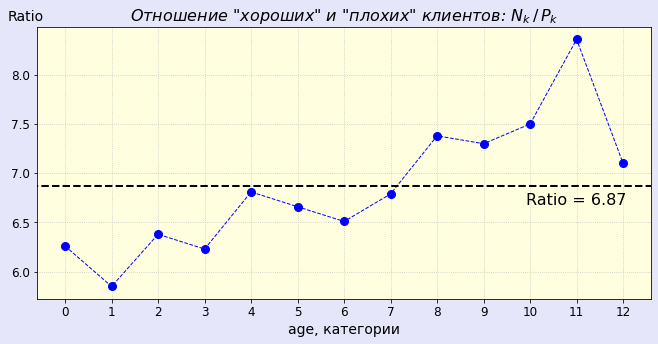

In [100]:
#------------------------------------------------------------------------------#
ratio = df_info.count_N.sum() / df_info.count_P.sum()
#---
fig, ax = plt.subplots(figsize=(11, 5))
plt.plot(df_info.index, df_info.ratio_NP.values, color='b', lw=1, marker='o',
         markersize=8, ls='--')
ax.set_xlim(*ax.get_xlim())
plt.plot([-1e7, 1e7], [ratio, ratio], lw=2, ls='--', color='k')
ax.set_xticks(df_info.index); ax.set_xlabel(f'{col}, категории')
ax.set_ylabel('Ratio', rotation=0, position=(0.,1.01), ha='left')
ax.set_title(r'Отношение "хороших" и "плохих" клиентов: $N_k\,/\,P_k$',
             fontstyle='italic')
ax.text(11, 6.8, f'Ratio = {ratio:.2f}', ha='center', va='top');
df_info[['spans', 'ratio_NP']].T.rename_axis(columns=['categories:'])

Ясно виден тренд на увеличение надёжности заёмщиков с возрастом. Максимум наблюдается для клиентов в возрасте от 52 до 58 лет. Затем идёт спад на самых возрастных клиентах "за 60". Впрочем, даже самые возрастные клиенты надёжнее молодых клиентов: наименее ответственными являются клиенты в диапазоне от 25 до 27 лет.  
В категории наименее ответственных заёмщиков на каждого "дефолтника" приходится 5.85 ответственных клиентов. В группе наиболее ответственных клиентов на каждого "дефолтника" имеем 8.36 надёжных заёмщиков, т.е. почти в полтора (1.4) раза больше.

Итак, получили начальное разбиение признака на категории. Посмотрим на распределение WoE и IV по данным категориям и на интегральную величину IV, отражающую предсказательную силу признака.

,age
IV,0.0089


categories:,0,1,2,3,4,5,6,7,8,9,10,11,12
spans,"[-inf, 25.0]","[25.0, 27.0]","[27.0, 29.0]","[29.0, 31.0]","[31.0, 33.0]","[33.0, 35.0]","[35.0, 38.0]","[38.0, 40.0]","[40.0, 44.0]","[44.0, 48.0]","[48.0, 52.0]","[52.0, 58.0]","[58.0, inf]"
WoE,0.093877,0.162194,0.074746,0.09804,0.008732,0.032151,0.054061,0.011709,-0.070723,-0.060276,-0.087199,-0.195731,-0.032082
IV,0.000639,0.00179,0.000416,0.000723,0.000005,0.000067,0.000264,0.000008,0.000497,0.000289,0.00055,0.003581,0.000084


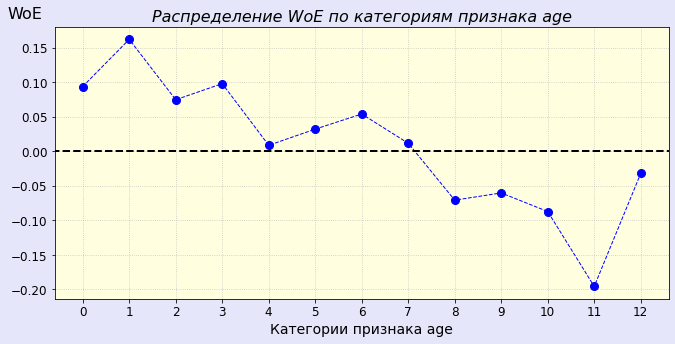

In [101]:
#------------------------------------------------------------------------------#
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Нет ничего удивительного в том, что график Ratio и график WoE демонстрируют схожий характер изменения, ведь для $k$-ой категории ($k$-го диапазона) $\Delta_{ik}$ $i$-го признака справедливо выражение:
$$
WoE_{ik} = \ln \left( \frac{p(x \in \Delta_{ik}\,|\,y = 1)}{p(x \in \Delta_{ik}\,|\,y = 0)} \right) = \ln \left( \frac{N_{1,\,ik}\,N_{0,\,tot}}{N_{0,\,ik}\,N_{1,\,tot}} \right) = \ln \left( \frac{ N_{1,\,ik} }{ N_{0,\,ik} } \right) + \ln \left( \frac{ N_{0,\,tot} }{ N_{1,\,tot} } \right) = - \ln \left( Ratio_{ik} \right) - \ln \left( \frac{ p(y = 1) }{ p(y = 0) } \right) = - \ln \left( Ratio_{ik} \right) - \text{intercept}.
$$
В этом выражении $N_{1,\,ik}$ и $N_{0,\,ik}$ - количество "дефолтных" и "не-дефолтных" клиентов в $k$-ом диапазоне $i$-го признака, а $N_{1,\,tot}$ и $N_{0,\,tot}$ - количество "дефолтных" и "не-дефолтных" клиентов во всём датасете с известными метками классов; $Ratio_{ik} = N_{0,\,ik}\,/\,N_{1,\,ik}$.  
Обозначим для краткости: $C = - \text{intercept}$. Очевидно, что $C$ - положительная константа: $C = \ln (6.87) \approx 1.93$. Получаем связь:
$$
WoE_{ik} = C - \ln \left( Ratio_{ik} \right).
$$
Проверяем:

In [102]:
#------------------------------------------------------------------------------#
df_WoE_Ratio = df_cat.copy()
Ratio_ik = df_cat['count_N'] / df_cat['count_P']
df_WoE_Ratio['C - ln(Ratio)'] = np.around(np.log(ratio) - np.log(Ratio_ik), 4)
df_WoE_Ratio['WoE'] = np.around(df_WoE_Ratio['WoE'], 4)
df_WoE_Ratio['delta'] = df_WoE_Ratio['WoE'] - df_WoE_Ratio['C - ln(Ratio)']
df_WoE_Ratio[['spans', 'WoE', 'C - ln(Ratio)', 'delta']]

,spans,WoE,C - ln(Ratio),delta
0,"[-inf, 25.0]",0.0939,0.0939,0.0
1,"[25.0, 27.0]",0.1622,0.1622,0.0
2,"[27.0, 29.0]",0.0747,0.0747,0.0
3,"[29.0, 31.0]",0.0980,0.0980,0.0
4,"[31.0, 33.0]",0.0087,0.0087,0.0
5,"[33.0, 35.0]",0.0322,0.0322,0.0
6,"[35.0, 38.0]",0.0541,0.0541,0.0
7,"[38.0, 40.0]",0.0117,0.0117,0.0
8,"[40.0, 44.0]",-0.0707,-0.0707,0.0
9,"[44.0, 48.0]",-0.0603,-0.0603,0.0


Вернёмся к полученному распределению WoE по диапазонам (категориям) признака `age`. Оно не является оптимальным - в том смысле, что некоторые категории можно объединить. На примере признака `age` продемонстрируем простой и достаточно удобный способ объединения категорий для "дискретизированного" непрерыного признака. Для этого сначала взглянем на то, как именно соотносятся категории признака с границами категорий. Список edges_list, который вернула функция get_binned_feature, содержит данные о возрасте. Эти данные соответствуют квантилям разбиения признака `age` по клиентам _**миноритарного**_ класса.

14 границ дадут на 1 меньшее количество интервалов, на которые эти границы разбивают признак `age`, т.е. 13 интервалов, 13 категорий признака `age`. Посмотрим, как это выглядит графически.

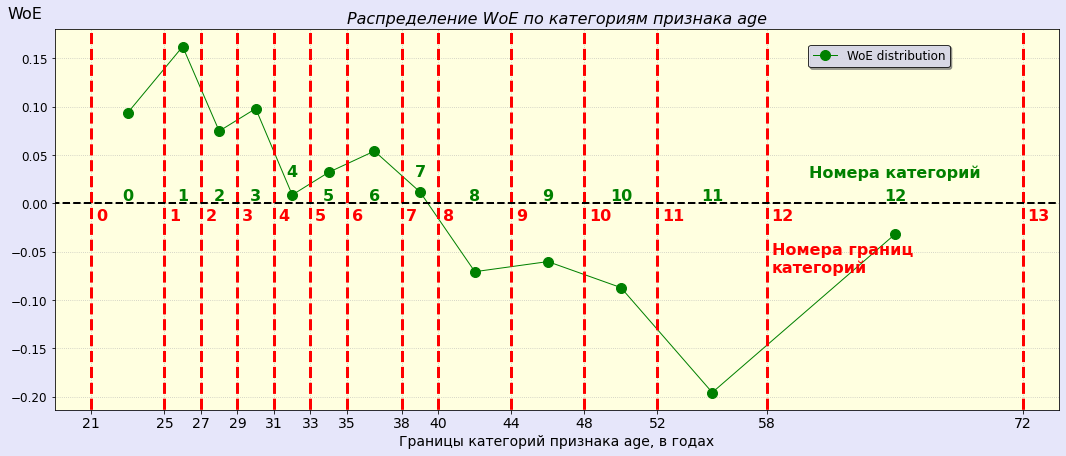

In [103]:
#------------------------------------------------------------------------------#
WoE = df_cat['WoE']
# Для нормального отображения крайних левой и правой границ списка edges_list
# заменим -inf и +inf на min и max по всем 110 тыс. клиентам:
edg_lst = edges_list.copy()
edg_lst[0] = data[col].min(); edg_lst[-1] = data[col].max()
edg_lst = [int(edg_lst[k]) for k in range(len(edg_lst))]
# Размещаем категорию в центре соответствующего диапазона:
x_cat = [0.5 * (edg_lst[k] + edg_lst[k+1]) for k in range(len(edg_lst)-1)]
#---
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(x_cat, WoE.values, lw=1, color='g', marker='o', markersize=10,
         label='WoE distribution'); ax.legend(loc=(0.75,0.9))
#---
ax.set_xticks(edg_lst); ax.set_xlim(edg_lst[0] - 2, edg_lst[-1] + 2);
ax.set_xticklabels(edg_lst, size=14)
ax.set_ylabel('WoE', rotation=0, position=(0.,1.02), fontsize=16, ha='left')
ax.set_xlabel(f'Границы категорий признака {col}, в годах')
ax.set_title(f'Распределение WoE по категориям признака {col}', style='italic');
# Акцентируем границы диапазонов:
ymin = ax.get_ylim()[0]; ymax = ax.get_ylim()[1]
for val in edg_lst:
    plt.plot([val, val], [-10, +10], lw=3, c='red', ls='--')
ax.set_ylim(ymin, ymax);
plt.plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--') # Линия нуля.
#------------------------------------------------------------------------------#
for cat in df_cat.index:
    if cat in [4, 7]:
        ax.text(x=x_cat[cat], y=0.025, s=f'{cat}', va='bottom', ha='center', 
                color='g', fontweight='bold');
        continue
    ax.text(x=x_cat[cat], y=0, s=f'{cat}', va='bottom', ha='center',
            color='g', fontweight='bold');
ax.text(x=x_cat[12], y=0.04, s='Номера категорий', va='top', ha='center',
       color='g', fontweight='bold');
for k, val in enumerate(edg_lst):
    ax.text(x=edg_lst[k]+0.25, y=-0.005, s=f'{k}', va='top', ha='left',
            color='r', fontweight='bold');
ax.text(x=edg_lst[12]+0.25, y=-0.04, s='Номера границ\nкатегорий', va='top',
        ha='left', color='r', fontweight='bold');

Итак, мы видим, что удобнее всего ассоциировать номер категории (0, 1, ...) с номером _**левой**_ границы категории. Например, категория номер 11 заключена в границах 52 года и 58 лет. Левая граница (52 года) этого диапазона имеет тот же номер 11.  
В данном распределении WoE можно выделить 6 групп категорий:

>1: Категории 0 и 1
>
>2: 2 и 3
>
>3: 4, 5, 6 и 7
>
>4: 8, 9 и 10
>
>5: Категория 11
>
>6: Категория 12

Группы 5 и 6 состоят из одной категории каждая. Категории внутри остальных групп мы объединим (внутри группы). Для осуществления такого объединения поступим следующим способом. Например, мы хотим объединить категории 0 и 1 в одну категорию. Для этого уберём из списка _**границ**_ категорий границу номер 1 (25 лет) и пересчитаем WoE.

,age
IV,0.0087


categories:,0,1,2,3,4,5,6,7,8,9,10,11
spans,"[-inf, 27.0]","[27.0, 29.0]","[29.0, 31.0]","[31.0, 33.0]","[33.0, 35.0]","[35.0, 38.0]","[38.0, 40.0]","[40.0, 44.0]","[44.0, 48.0]","[48.0, 52.0]","[52.0, 58.0]","[58.0, inf]"
WoE,0.126941,0.074746,0.09804,0.008732,0.032151,0.054061,0.011709,-0.070723,-0.060276,-0.087199,-0.195731,-0.032082
IV,0.002265,0.000416,0.000723,0.000005,0.000067,0.000264,0.000008,0.000497,0.000289,0.00055,0.003581,0.000084


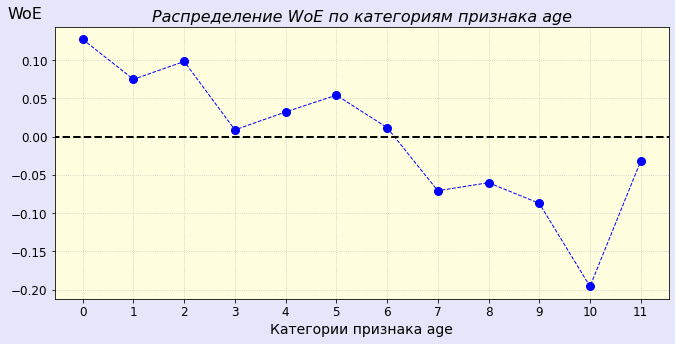

In [104]:
#------------------------------------------------------------------------------#
# Удаляем границу 1 - между категориями 0 и 1:
for_del = [edges_list[1]]
[edges_list.remove(x) for x in for_del]
#---
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Видим, что категория "25 лет" исчезла, а количество категорий сократилось на 1. Довершим начатое и совершим "групповое" объединение категорий:
* 1 и 2
* 3, 4, 5 и 6
* 7, 8 и 9

То есть уберём границы с соответствующими номерами: для объединения категорий 1 и 2 уберём из edges_list элемент с номером 2 и т.д.

,age
IV,0.0086


categories:,0,1,2,3,4,5
spans,"[-inf, 27.0]","[27.0, 31.0]","[31.0, 40.0]","[40.0, 52.0]","[52.0, 58.0]","[58.0, inf]"
WoE,0.126941,0.086444,0.029163,-0.072161,-0.195731,-0.032082
IV,0.002265,0.001119,0.00024,0.001308,0.003581,0.000084


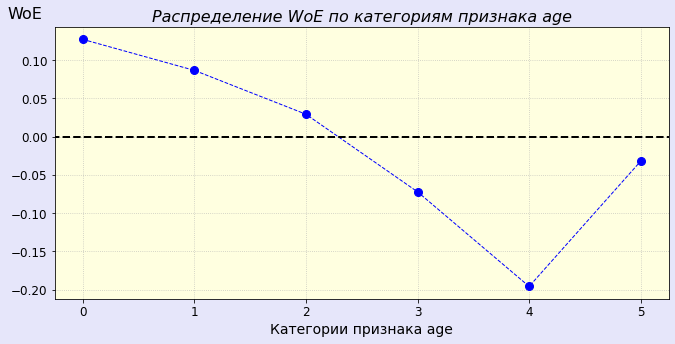

In [105]:
#------------------------------------------------------------------------------#
for_del = [edges_list[2],
           edges_list[4], edges_list[5], edges_list[6],
           edges_list[8], edges_list[9]]
[edges_list.remove(x) for x in for_del]
#---
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Такое распределение WoE нас устраивает. Самую возрастную категорию (номер 5 в данном случае) я не стал убирать, т.к. она отражает характерную закономерность: клиенты весьма почтенного возраста входят, так сказать, в группу риска. Впрочем, для 5-ой категории WoE < 0, т.е. данная категория благоприятствует событию "Не-Дефолт".

Итак, признак `age` обладает ничтожной предсказательной силой, судя по IV: IV = 0.0086 < 0.02. Но мы его пока оставим.
***

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [106]:
#------------------------------------------------------------------------------#
data[col] = np.digitize(data[col], bins=edges_list, right=False)
dct = {k+1: df_cat.loc[k, 'WoE'] for k in df_cat.index}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [107]:
#------------------------------------------------------------------------------#
df = df_cat[['WoE', 'IV']].copy()
idx = pd.Index([f'{col}_{df_cat.index[k]}' for k in df_cat.index])
df.set_index(idx, inplace=True)
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.881     0.444     0.590     12886
      Дефолт      0.133     0.587     0.217      1874

    accuracy                          0.462     14760
   macro avg      0.507     0.516     0.404     14760
weighted avg      0.786     0.462     0.543     14760


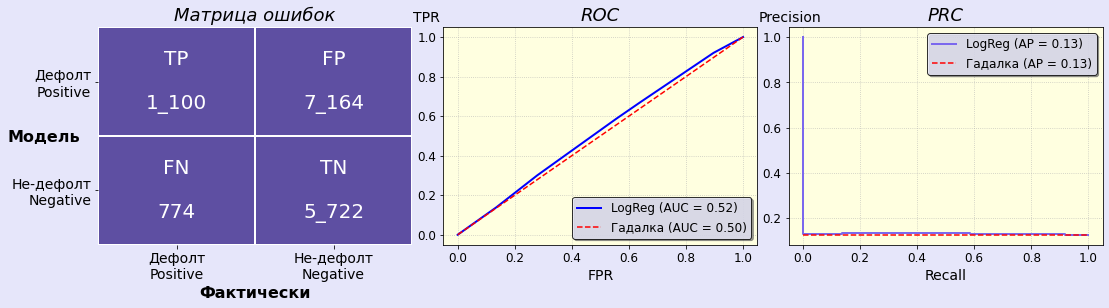

In [108]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [109]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520


### 3.13. Признак `app_date`.
Признак `app_date` - это временной признак, и факт наличия такого признака в нашем наборе данных вносит "параболичность" в датасет, т.е. однонаправленность, изменение во времени. Если бы я мог начать анализ заново, я бы воспользовался этой параболичностью, т.е. рассматривал бы все признаки меняющимися во времени, но это уже совсем другой подход.

Обычно временной признак - он как луковица. Первый слой - тренд, низкочастотные колебания, например, в масштабе годов. Второй слой - сезонные изменения, т.е. в масштабе года. Третий слой состоит из колебаний масштаба месяца. Четвёртый слой - внутринедельные колебания (будние дни - выходные дни). Высокочастотный слой включает колебания в течение суток и т.п. вплоть до случайной составляющей.  
Признак `app_date` представляет собой данные за первые четыре месяца 2014-го года с минимальным "квантом" в один день, т.е. 120 дней. В Разделе 2 мы видели, что на гистограмме хорошо видны колебания в масштабе недели - пики по пять дней и спад на двух выходных днях. Посмотрим, как это выглядит в терминах WoE. При этом мы сосредоточимся на средних по месяцам - в конце концов, большое количество категорий признака весьма неудобно.

In [110]:
df = data[data.flag=='train'][['app_date', 'default']].copy()
col = 'app_date'
df[col] = pd.to_datetime(df[col])
# Количество дней от начала года:
df['num_day'] = (df[col] - df[col].min()).dt.days
# Месяцы:
df['month'] = df[col].dt.strftime('%B')
# Дни месяца:
df['day'] = df[col].dt.day
# Дни недели:
df['wday'] = df[col].dt.week
#---
display(df)
#---
m_list = ['January', 'February', 'March', 'April']

,app_date,default,num_day,month,day,wday
0,2014-02-01,0,31,February,1,5
1,2014-03-12,0,70,March,12,11
2,2014-02-01,0,31,February,1,5
3,2014-01-23,0,22,January,23,4
4,2014-04-18,0,107,April,18,16
...,...,...,...,...,...,...
73794,2014-03-04,0,62,March,4,10
73795,2014-03-24,0,82,March,24,13
73796,2014-04-22,0,111,April,22,17
73797,2014-01-04,1,3,January,4,1


In [111]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
count_P_tot = df[df.default==1].shape[0]
count_N_tot = df[df.default==0].shape[0]
# Класс "Дефолт":
count_P = df['num_day'][df.default==1].value_counts().sort_index()
count_P.name = 'count_P'
# Класс "Не-Дефолт":
count_N = df['num_day'][df.default==0].value_counts().sort_index()
count_N.name = 'count_N'
# Ratio:
Ratio = count_N / count_P
Ratio.name = 'Ratio'
# WoE:
WoE = np.log( (count_P / count_P_tot) / (count_N / count_N_tot) )
WoE.name = 'WoE'
#---
df_WoE = df_(count_P).join(df_(count_N)).join(df_(Ratio)).join(df_(WoE))

In [112]:
#------------------------------------------------------------------------------#
df_WoE = df_WoE.join(df.set_index('num_day')[['month']]).drop_duplicates()
df_WoE

,count_P,count_N,Ratio,WoE,month
0,6,37,6.166667,0.108648,January
1,18,119,6.611111,0.039055,January
2,24,169,7.041667,-0.024039,January
3,51,239,4.686275,0.383168,January
4,33,242,7.333333,-0.064624,January
...,...,...,...,...,...
115,42,383,9.119048,-0.282559,April
116,41,291,7.097561,-0.031945,April
117,53,537,10.132075,-0.387900,April
118,34,338,9.941176,-0.368879,April


In [113]:
# Класс "Дефолт":
count_P = df[df.default==1]['month'].value_counts().loc[m_list]
# Класс "Не-Дефолт":
count_N = df[df.default==0]['month'].value_counts().loc[m_list]
# Ratio:
Ratio = count_N / count_P
Ratio.name = 'Ratio'
# WoE:
WoE = np.log( (count_P / count_P_tot) / (count_N / count_N_tot) )
WoE.name = 'WoE'
#---
df_month_WoE = df_(Ratio).join(df_(WoE))
df_month_WoE = df_month_WoE.reset_index().rename(columns={'index': 'month'})
df_month_WoE

,month,Ratio,WoE
0,January,6.025343,0.131832
1,February,6.539941,0.049878
2,March,6.840800,0.004902
3,April,8.441004,-0.205295


In [114]:
df_WoE = df_WoE.merge(df_month_WoE, on='month', suffixes=('', '_month'))
df_WoE

,count_P,count_N,Ratio,WoE,month,Ratio_month,WoE_month
0,6,37,6.166667,0.108648,January,6.025343,0.131832
1,18,119,6.611111,0.039055,January,6.025343,0.131832
2,24,169,7.041667,-0.024039,January,6.025343,0.131832
3,51,239,4.686275,0.383168,January,6.025343,0.131832
4,33,242,7.333333,-0.064624,January,6.025343,0.131832
...,...,...,...,...,...,...,...
115,42,383,9.119048,-0.282559,April,8.441004,-0.205295
116,41,291,7.097561,-0.031945,April,8.441004,-0.205295
117,53,537,10.132075,-0.387900,April,8.441004,-0.205295
118,34,338,9.941176,-0.368879,April,8.441004,-0.205295


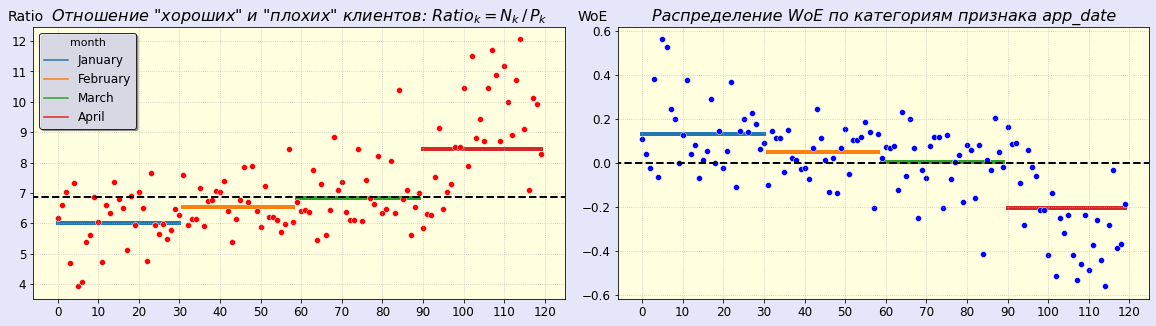

In [115]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(20, 5)); fig.subplots_adjust(wspace=0.1)
sns.scatterplot(data=df_WoE, x=df_WoE.index, y='Ratio', color='r', ax=ax[0]);
sns.lineplot(data=df_WoE, x=df_WoE.index, y='Ratio_month', hue='month',
             palette='tab10', ax=ax[0], lw=4, zorder=0);
sns.scatterplot(data=df_WoE, x=df_WoE.index, y='WoE', color='b', ax=ax[1]);
sns.lineplot(data=df_WoE, x=df_WoE.index, y='WoE_month', hue='month',
             palette='tab10', ax=ax[1], lw=4, zorder=0, legend=False);
[axs.set_xticks(range(0,130,10)) for axs in ax];
[axs.set_ylabel(axs.get_ylabel(), rotation=0, position=(0,1.01), ha='left')
 for axs in ax];
ax[0].set_title(r'Отношение "хороших" и "плохих" клиентов: $Ratio_k = N_k\,/\,P_k$',
                style='italic');
ax[1].set_title(f'Распределение WoE по категориям признака {col}',
                style='italic');
#------------------------------------------------------------------------------#
ratio = data[data.default==0].shape[0] / data[data.default==1].shape[0]
ratio = round(ratio, 2)
ax[0].set_xlim(*ax[0].get_xlim())
ax[0].plot([-1e7, 1e7], [ratio, ratio], lw=2, c='k', ls='--');
ax[1].set_xlim(*ax[1].get_xlim())
ax[1].plot([-1e7, 1e7], [0, 0], lw=2, c='k', ls='--'); # Линия нуля.

Итак, наблюдаем любопытную ситуацию. Среди январских клиентов большой процент "дефолтников", для них WoE имеет наибольшее по модулю положительное значение. Положительность WoE означает, как мы помним, повышенную вероятность дефолта по кредиту. В то же время (хотя нет, спустя три месяца) апрельские клиенты наиболее надёжные - у них WoE отрицательный, т.е. благоприятствует возврату кредита.

Чем вызвана такая закономерность? Сложно сказать наверняка. Впрочем, это же 2014-ый год, именно в этом году Крым воссоединился с Россией - в марте месяце произошёл референдум. Возможно, народ воодушевился этой новостью и ...

In [116]:
e_list = [0]
for m in m_list:
    e_list.append(df_WoE[df_WoE.month==m].index.max()+1)
e_list

[0, 31, 59, 90, 120]

,app_date
IV,0.0142


categories:,0,1,2,3
spans,"[0, 31]","[31, 59]","[59, 90]","[90, 120]"
WoE,0.131832,0.049878,0.004902,-0.205295
IV,0.004182,0.000619,0.000007,0.00935


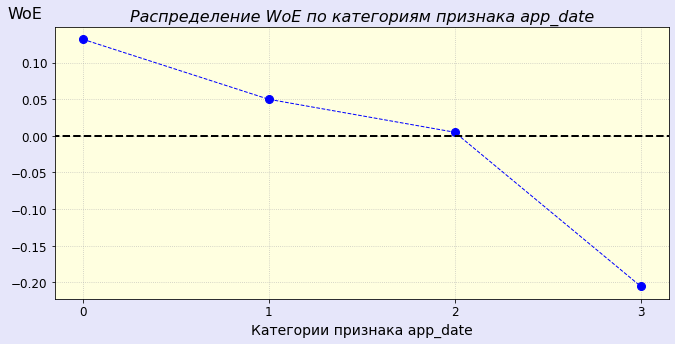

In [117]:
df = data[data.flag=='train'][['app_date', 'default']].copy()
col = 'app_date'
df[col] = pd.to_datetime(df[col])
# Количество дней от начала года:
df[col] = (df[col] - df[col].min()).dt.days
df_cat, df_IV = get_WoE_and_IV(df, col, e_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [118]:
#------------------------------------------------------------------------------#
data[col] = pd.to_datetime(data[col])
data[col] = (data[col] - data[col].min()).dt.days
#---
data[col] = np.digitize(data[col], bins=e_list, right=False)
dct = {k+1: df_cat.loc[k, 'WoE'] for k in df_cat.index}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [119]:
#------------------------------------------------------------------------------#
df = df_cat[['WoE', 'IV']].copy()
idx = pd.Index([f'{col}_{df_cat.index[k]}' for k in df_cat.index])
df.set_index(idx, inplace=True)
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.886     0.246     0.385     12886
      Дефолт      0.131     0.782     0.225      1874

    accuracy                          0.314     14760
   macro avg      0.509     0.514     0.305     14760
weighted avg      0.790     0.314     0.365     14760


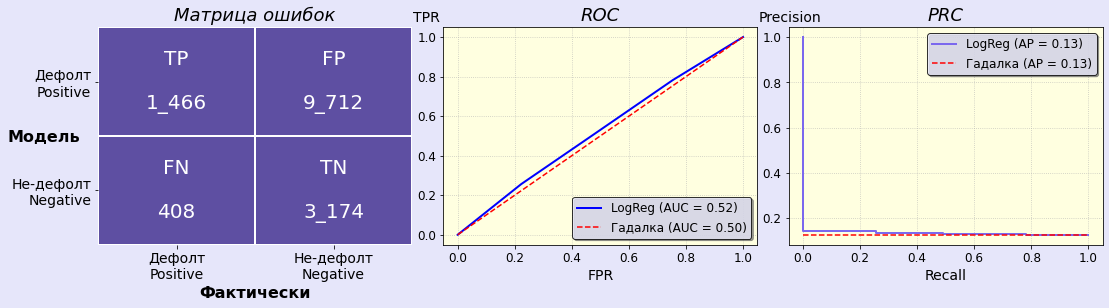

In [120]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [121]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age,app_date
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009,0.014
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404,0.305
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021,0.022
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520,0.524


Итак, признак `app_date` обладает ничтожной предсказательной силой, судя по IV: IV = 0.014 < 0.02. Но мы его пока оставим.

### 3.14. Признак `decline_app_cnt`.
Поступим как в Разделе 2: "отрежем" всё, что больше процентиля 99% и поместим в отдельную категорию.

In [122]:
#------------------------------------------------------------------------------#
col = 'decline_app_cnt'
q_99 = np.percentile(data[col], 99.)
print(f'Процентиль 99% : {q_99}')
#---
data[col] = data[col].apply(lambda x: q_99 + 1 if x > q_99 else x).astype(int)
data[col].value_counts().sort_index()

Процентиль 99% : 4.0


0    91471
1    12500
2     3622
3     1365
4      606
5      584
Name: decline_app_cnt, dtype: int64

,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,decline_app_cnt_5
count_class_P,6705.000000,1577.000000,601.000000,247.000000,120.000000,122.000000
count_class_N,54509.000000,6820.000000,1867.000000,656.000000,294.000000,281.000000
count_total,61214.000000,8397.000000,2468.000000,903.000000,414.000000,403.000000
"fraction, %",82.900000,11.400000,3.300000,1.200000,0.600000,0.500000
WoE,-0.167706,0.463471,0.794313,0.951034,1.031718,1.093473
IV,0.021907,0.028926,0.027919,0.015381,0.008502,0.009465


,decline_app_cnt
IV,0.112


{'decline_app_cnt': [0, 1, 2, 3, 4, 5]}


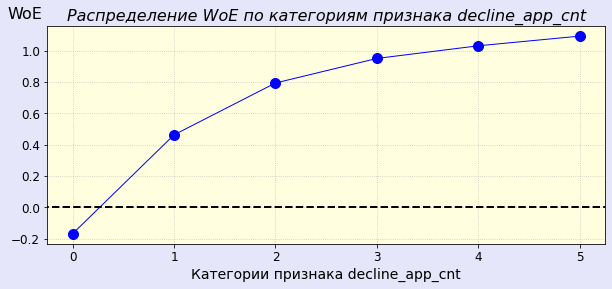

In [123]:
#------------------------------------------------------------------------------#
df = data.copy()
cat_order = sorted(data[col].unique().tolist())
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Категории 2 - 5 слабо населены (< 5%). Объединим их в одну категорию.

In [124]:
#------------------------------------------------------------------------------#
data[col] = data[col].replace([3, 4, 5], 2)
data[col].value_counts().sort_index()

0    91471
1    12500
2     6177
Name: decline_app_cnt, dtype: int64

,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2
count_class_P,6705.000000,1577.000000,1090.000000
count_class_N,54509.000000,6820.000000,3098.000000
count_total,61214.000000,8397.000000,4188.000000
"fraction, %",82.900000,11.400000,5.700000
WoE,-0.167706,0.463471,0.883227
IV,0.021907,0.028926,0.060252


,decline_app_cnt
IV,0.111


{'decline_app_cnt': ['decline_app_cnt_0', 'decline_app_cnt_1', 'decline_app_cnt_2']}


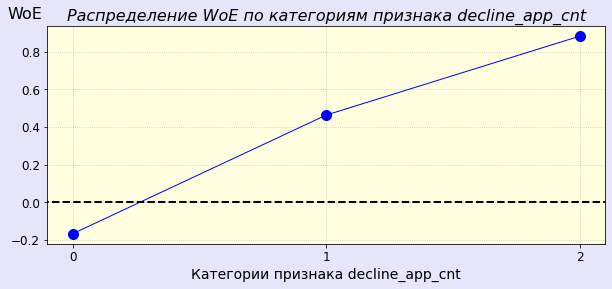

In [125]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

Таким образом, признак `decline_app_cnt` преобразован в три категории. Судя по IV = 0.111, этот признак обладает средней прогностической способностью: 0.1 < IV < 0.3.

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [126]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.167706    91471
 0.463471    12500
 0.883227     6177
Name: decline_app_cnt, dtype: int64

Запоминаем информацию по WoE и IV для признака.

In [127]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

Посчитаем логистическую регрессию на одном признаке.

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.892     0.846     0.869     12886
      Дефолт      0.220     0.297     0.253      1874

    accuracy                          0.777     14760
   macro avg      0.556     0.572     0.561     14760
weighted avg      0.807     0.777     0.791     14760


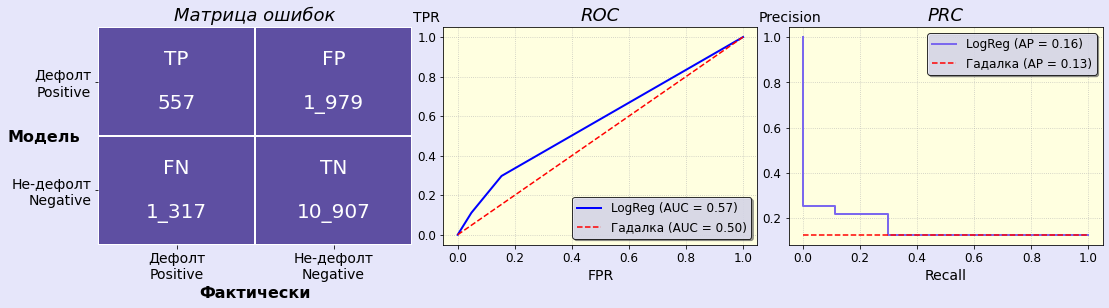

In [128]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

Сводная таблица.

In [129]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age,app_date,decline_app_cnt
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009,0.014,0.111
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404,0.305,0.561
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021,0.022,0.127
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520,0.524,0.573


### 3.15. Признак `bki_request_cnt`.
Поступим как в Разделе 2: "отрежем" всё, что больше процентиля 99% и поместим в отдельную категорию.

In [130]:
#------------------------------------------------------------------------------#
col = 'bki_request_cnt'
q_99 = np.percentile(data[col], 99)
print(f'Процентиль 99% : {q_99}')
#---
data[col] = data[col].apply(lambda x: q_99 + 1 if x > q_99 else x).astype(int)
data[col].value_counts().sort_index()

Процентиль 99% : 10.0


0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11     1092
Name: bki_request_cnt, dtype: int64

,bki_request_cnt_0,bki_request_cnt_1,bki_request_cnt_2,bki_request_cnt_3,bki_request_cnt_4,bki_request_cnt_5,bki_request_cnt_6,bki_request_cnt_7,bki_request_cnt_8,bki_request_cnt_9,bki_request_cnt_10,bki_request_cnt_11
count_class_P,1841.000000,2171.000000,1820.000000,1338.000000,851.000000,554.000000,279.000000,134.000000,98.000000,58.000000,40.000000,188.000000
count_class_N,17540.000000,16105.000000,11929.000000,7849.000000,4776.000000,2714.000000,1425.000000,718.000000,410.000000,241.000000,185.000000,535.000000
count_total,19381.000000,18276.000000,13749.000000,9187.000000,5627.000000,3268.000000,1704.000000,852.000000,508.000000,299.000000,225.000000,723.000000
"fraction, %",26.300000,24.800000,18.600000,12.400000,7.600000,4.400000,2.300000,1.200000,0.700000,0.400000,0.300000,1.000000
WoE,-0.326369,-0.076136,0.047670,0.158596,0.202860,0.338792,0.297091,0.249177,0.496617,0.503452,0.396330,0.881981
IV,0.024742,0.001395,0.000431,0.003321,0.003382,0.005755,0.002273,0.000786,0.002033,0.001232,0.000554,0.010368


,bki_request_cnt
IV,0.056


{'bki_request_cnt': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}


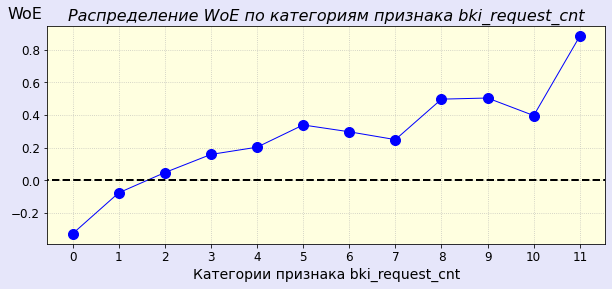

In [131]:
#------------------------------------------------------------------------------#
df = data.copy()
cat_order = sorted(data[col].unique().tolist())
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                                            df, col, cat_order)
display(df_cat); display(df_IV); print(cat_dict)

Населённость категорий с 5-ой по 11-ую ниже 5%. Объединим их.

In [132]:
#------------------------------------------------------------------------------#
data[col] = data[col].replace([6, 7, 8, 9, 10, 11], 5)
data[col].value_counts().sort_index()

0    28908
1    27295
2    20481
3    13670
4     8406
5    11388
Name: bki_request_cnt, dtype: int64

,bki_request_cnt_0,bki_request_cnt_1,bki_request_cnt_2,bki_request_cnt_3,bki_request_cnt_4,bki_request_cnt_5
count_class_P,1841.000000,2171.000000,1820.000000,1338.000000,851.000000,1351.000000
count_class_N,17540.000000,16105.000000,11929.000000,7849.000000,4776.000000,6228.000000
count_total,19381.000000,18276.000000,13749.000000,9187.000000,5627.000000,7579.000000
"fraction, %",26.300000,24.800000,18.600000,12.400000,7.600000,10.300000
WoE,-0.326369,-0.076136,0.047670,0.158596,0.202860,0.399596
IV,0.024742,0.001395,0.000431,0.003321,0.003382,0.018975


,bki_request_cnt
IV,0.052


{'bki_request_cnt': ['bki_request_cnt_0', 'bki_request_cnt_1', 'bki_request_cnt_2', 'bki_request_cnt_3', 'bki_request_cnt_4', 'bki_request_cnt_5']}


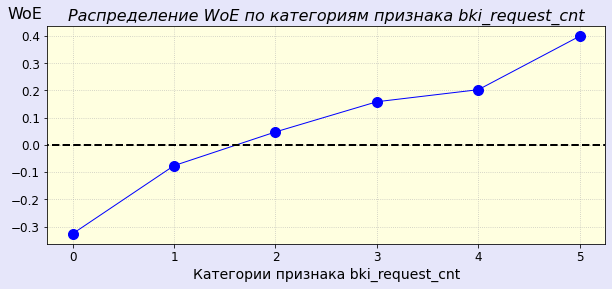

In [133]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

У категорий 3 и 4 величины WoE близки. Объединим эти категории.

In [134]:
data[col] = data[col].replace(4, 3)
data[col] = data[col].replace(5, 4)
data[col].value_counts().sort_index()

0    28908
1    27295
2    20481
3    22076
4    11388
Name: bki_request_cnt, dtype: int64

,bki_request_cnt_0,bki_request_cnt_1,bki_request_cnt_2,bki_request_cnt_3,bki_request_cnt_4
count_class_P,1841.000000,2171.000000,1820.000000,2189.000000,1351.000000
count_class_N,17540.000000,16105.000000,11929.000000,12625.000000,6228.000000
count_total,19381.000000,18276.000000,13749.000000,14814.000000,7579.000000
"fraction, %",26.300000,24.800000,18.600000,20.100000,10.300000
WoE,-0.326369,-0.076136,0.047670,0.175572,0.399596
IV,0.024742,0.001395,0.000431,0.006603,0.018975


,bki_request_cnt
IV,0.052


{'bki_request_cnt': ['bki_request_cnt_0', 'bki_request_cnt_1', 'bki_request_cnt_2', 'bki_request_cnt_3', 'bki_request_cnt_4']}


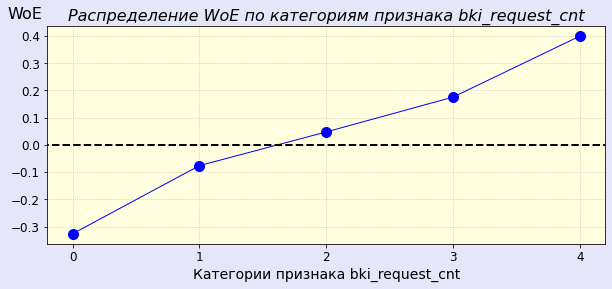

In [135]:
#------------------------------------------------------------------------------#
df = data.copy()
df_cat, df_IV, cat_dict = get_WoE_and_IV_for_categoric_feature(
                                        df, col, cat_order, to_replace=False)
display(df_cat); display(df_IV); print(cat_dict)

In [136]:
#------------------------------------------------------------------------------#
dct = {k: df_cat.loc['WoE', f'{col}_{k}'] for k in
                                           range(len(df_cat.columns.to_list()))}
data[col] = data[col].map(dct)
data[col].value_counts().sort_index()

-0.326369    28908
-0.076136    27295
 0.047670    20481
 0.175572    22076
 0.399596    11388
Name: bki_request_cnt, dtype: int64

In [137]:
#------------------------------------------------------------------------------#
df = df_cat.loc[['WoE', 'IV']].T
df_local_WoE_IV = df_local_WoE_IV.append(df)

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.894     0.517     0.655     12886
      Дефолт      0.148     0.576     0.235      1874

    accuracy                          0.525     14760
   macro avg      0.521     0.547     0.445     14760
weighted avg      0.799     0.525     0.602     14760


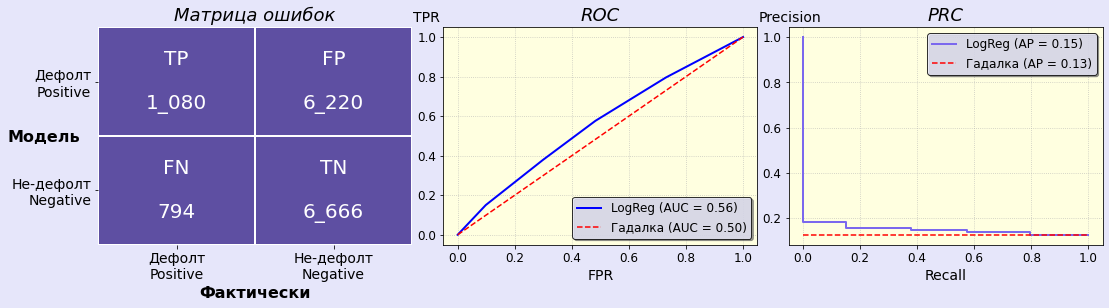

In [138]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

In [139]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age,app_date,decline_app_cnt,bki_request_cnt
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009,0.014,0.111,0.052
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404,0.305,0.561,0.445
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021,0.022,0.127,0.062
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520,0.524,0.573,0.560


Итак, признак `bki_request_cnt` дискретзирован в 5 категорий. Судя по IV = 0.052, предсказательная сила этого признака находится на низком уровне: 0.02 < IV < 0.1.

### 3.16. Признак `income`.

In [140]:
col = 'income'
df = data[data.flag=='train'].copy()
# Квантильная дискретизация. Ориентируемся на миноритарный класс.
count_bins = 30
df_info, edges_list = get_binned_feature(df, col, count_bins)
display(df_info); print(edges_list)

,spans,count_P,count_N,count_tot,"proba_P, %","proba_N, %",ratio_NP
0,"[-inf, 15000.0]",1045,6484,7529,11.2,10.1,6.20
1,"[15000.0, 20000.0]",1294,7136,8430,13.8,11.1,5.51
2,"[20000.0, 23000.0]",1037,5971,7008,11.1,9.3,5.76
3,"[23000.0, 28000.0]",1294,7771,9065,13.8,12.1,6.01
4,"[28000.0, 33000.0]",1150,7758,8908,12.3,12.0,6.75
5,"[33000.0, 40000.0]",835,5139,5974,8.9,8.0,6.15
6,"[40000.0, 55000.0]",1497,12009,13506,16.0,18.6,8.02
7,"[55000.0, inf]",1220,12159,13379,13.0,18.9,9.97


[-inf, 15000.0, 20000.0, 23000.0, 28000.0, 33000.0, 40000.0, 55000.0, inf]


,income
IV,0.0396


categories:,0,1,2,3,4,5,6,7
spans,"[-inf, 15000.0]","[15000.0, 20000.0]","[20000.0, 23000.0]","[23000.0, 28000.0]","[28000.0, 33000.0]","[33000.0, 40000.0]","[40000.0, 55000.0]","[55000.0, inf]"
WoE,0.102486,0.220392,0.177224,0.135146,0.018844,0.110624,-0.154387,-0.371412
IV,0.001113,0.006019,0.003185,0.002359,0.000043,0.001032,0.004117,0.021746


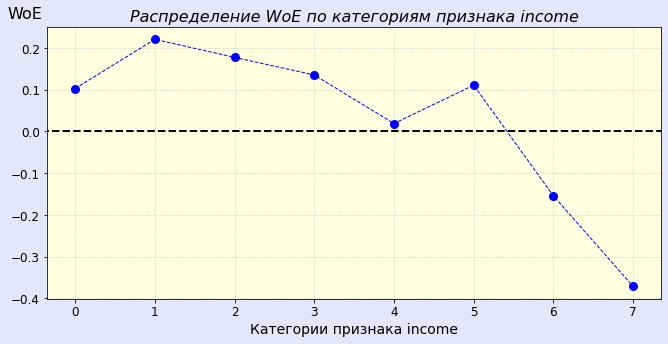

In [141]:
#------------------------------------------------------------------------------#
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

,income
IV,0.0384


categories:,0,1,2,3,4
spans,"[-inf, 23000.0]","[23000.0, 28000.0]","[28000.0, 40000.0]","[40000.0, 55000.0]","[55000.0, inf]"
WoE,0.169428,0.135146,0.05643,-0.154387,-0.371412
IV,0.009512,0.002359,0.000656,0.004117,0.021746


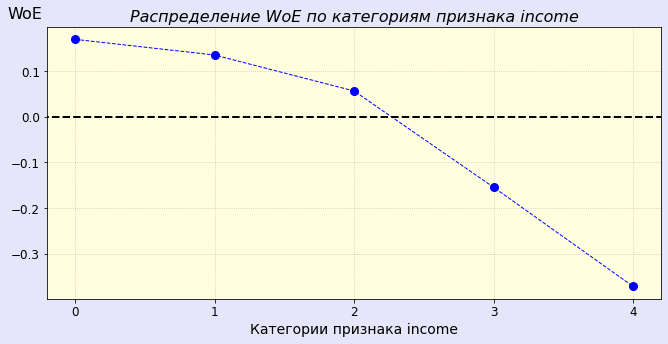

In [142]:
#------------------------------------------------------------------------------#
for_del = [edges_list[1], 
           edges_list[2],
           edges_list[5]]
[edges_list.remove(x) for x in for_del]
#---
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [143]:
#------------------------------------------------------------------------------#
data[col] = np.digitize(data[col], bins=edges_list, right=False)
dct = {k+1: df_cat.loc[k, 'WoE'] for k in df_cat.index}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [144]:
#------------------------------------------------------------------------------#
df = df_cat[['WoE', 'IV']].copy()
idx = pd.Index([f'{col}_{df_cat.index[k]}' for k in df_cat.index])
df.set_index(idx, inplace=True)
df_local_WoE_IV = df_local_WoE_IV.append(df)

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.896     0.379     0.533     12886
      Дефолт      0.140     0.696     0.233      1874

    accuracy                          0.420     14760
   macro avg      0.518     0.538     0.383     14760
weighted avg      0.800     0.420     0.495     14760


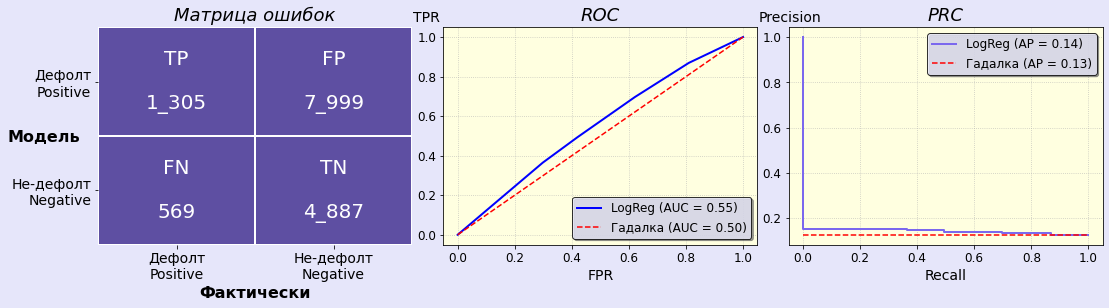

In [145]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

In [146]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age,app_date,decline_app_cnt,bki_request_cnt,income
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009,0.014,0.111,0.052,0.038
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404,0.305,0.561,0.445,0.383
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021,0.022,0.127,0.062,0.052
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520,0.524,0.573,0.560,0.552


Признак `income` разбили на 5 категорий. Судя по IV = 0.038, признак ообладает низкой прогностической способностью: 0.02 < IV < 0.1.

### 3.17. Признак `score_bki`.
В Разделе 1 мы видели, что распределение признака `score_bki` близко к нормальному распределению. Это означает, в частности, что квантильное разбиение такого признака даст более-менее равномерное распределение.

In [147]:
col = 'score_bki'
df = data[data.flag=='train'].copy()
# Квантильная дискретизация. Ориентируемся на миноритарный класс.
count_bins = 30
df_info, edges_list = get_binned_feature(df, col, count_bins)
display(df_info); print(edges_list)

,spans,count_P,count_N,count_tot,"proba_P, %","proba_N, %",ratio_NP
0,"[-inf, -2.249581635]",1172,17687,18859,12.5,27.5,15.09
1,"[-2.249581635, -2.015870515]",1171,11685,12856,12.5,18.1,9.98
2,"[-2.015870515, -1.8343061274999999]",1172,8770,9942,12.5,13.6,7.48
3,"[-1.8343061274999999, -1.68385688]",1171,7109,8280,12.5,11.0,6.07
4,"[-1.68385688, -1.521038705]",1171,6463,7634,12.5,10.0,5.52
5,"[-1.521038705, -1.3379222725]",1172,5224,6396,12.5,8.1,4.46
6,"[-1.3379222725, -1.1012118775000002]",1171,4220,5391,12.5,6.6,3.60
7,"[-1.1012118775000002, inf]",1172,3269,4441,12.5,5.1,2.79


[-inf, -2.249581635, -2.015870515, -1.8343061274999999, -1.68385688, -1.521038705, -1.3379222725, -1.1012118775000002, inf]


Да, по миноритарному классу (именно на него мы ориентируемся при осуществлении квантильной дискретизации) получаем равномерное квантильное разбиение - на каждом интервале оказывается 1 / 8 * 100% = 12.5%. 

,score_bki
IV,0.2712


categories:,0,1,2,3,4,5,6,7
spans,"[-inf, -2.249581635]","[-2.249581635, -2.015870515]","[-2.015870515, -1.8343061274999999]","[-1.8343061274999999, -1.68385688]","[-1.68385688, -1.521038705]","[-1.521038705, -1.3379222725]","[-1.3379222725, -1.1012118775000002]","[-1.1012118775000002, inf]"
WoE,-0.786312,-0.372642,-0.084819,0.124303,0.219571,0.433255,0.645829,0.902034
IV,0.117534,0.021025,0.000939,0.001815,0.005408,0.01905,0.038392,0.067034


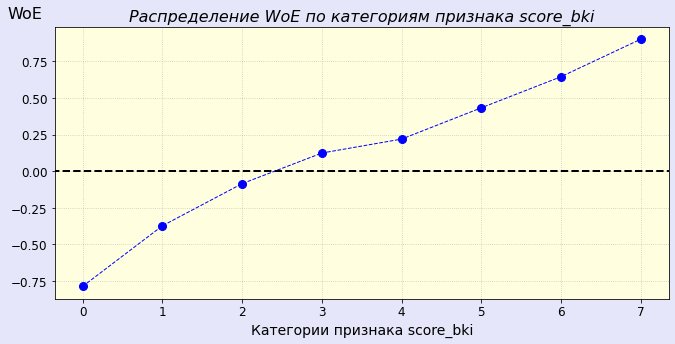

In [148]:
#------------------------------------------------------------------------------#
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Растущая зависимость WoE. Это означает, что распределение "хороших" клиентов сдвинуто влево, а "плохих" - вправо.

Медиана:
	- хорошие клиенты: -1.96
	- плохие клиенты: -1.68


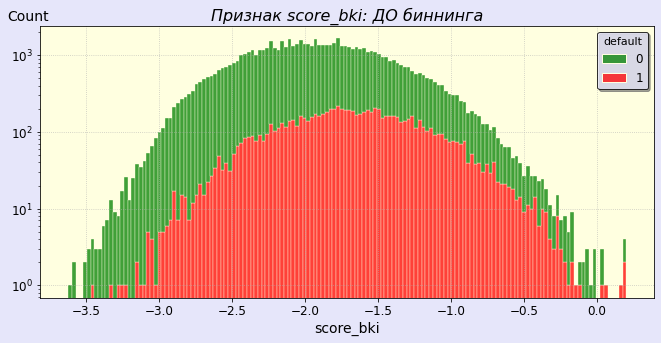

In [149]:
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(11, 5))
sns.histplot(data=df, x=col, bins=150, hue='default', palette=['g', 'r'],
             multiple="stack", edgecolor='lightyellow')
ax.set_title(f'Признак {col}: ДО биннинга', style='italic'); 
ax.set_ylabel('Count', rotation=0, position=(0,1.01), ha='left');
ax.set_yscale('log');
#---
med_val_N = df[df.default==0][col].median()
med_val_P = df[df.default==1][col].median()
print(f'Медиана:\n\t- хорошие клиенты: {med_val_N:.2f}')
print(f'\t- плохие клиенты: {med_val_P:.2f}')

Да, действительно, имеет место "расцентровка": медиана распределения "хороших" клиентов меньше, чем медиана распределения "плохих" клиентов.

В принципе, полученное распределение WoE вполне годное, но мы объединим категории 3 и 4, т.к. у них близкие значения WoE.

,score_bki
IV,0.2707


categories:,0,1,2,3,4,5,6
spans,"[-inf, -2.249581635]","[-2.249581635, -2.015870515]","[-2.015870515, -1.8343061274999999]","[-1.8343061274999999, -1.521038705]","[-1.521038705, -1.3379222725]","[-1.3379222725, -1.1012118775000002]","[-1.1012118775000002, inf]"
WoE,-0.786312,-0.372642,-0.084819,0.170803,0.433255,0.645829,0.902034
IV,0.117534,0.021025,0.000939,0.006702,0.01905,0.038392,0.067034


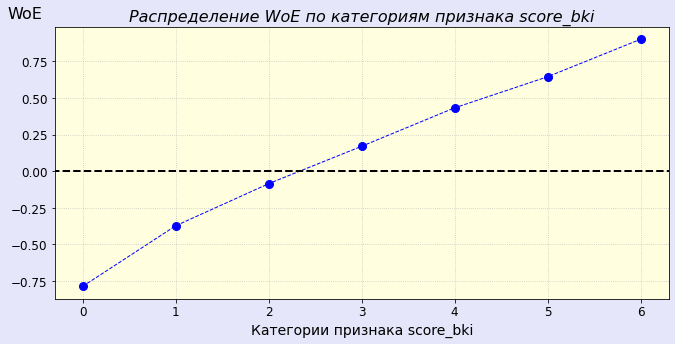

In [150]:
#------------------------------------------------------------------------------#
for_del = [edges_list[4]]
[edges_list.remove(x) for x in for_del]
#---
df_cat, df_IV = get_WoE_and_IV(df, col, edges_list)
display(df_IV)
display(df_cat[['spans', 'WoE', 'IV']].T.rename_axis(columns=['categories:']))

Красиво получилось...

Заменяем номера категорий на их WoE-значения - для всего датасета в 110 тысяч записей.

In [151]:
#------------------------------------------------------------------------------#
data[col] = np.digitize(data[col], bins=edges_list, right=False)
dct = {k+1: df_cat.loc[k, 'WoE'] for k in df_cat.index}
data[col] = data[col].map(dct)

Запоминаем информацию по WoE и IV для признака.

In [152]:
#------------------------------------------------------------------------------#
df = df_cat[['WoE', 'IV']].copy()
idx = pd.Index([f'{col}_{df_cat.index[k]}' for k in df_cat.index])
df.set_index(idx, inplace=True)
df_local_WoE_IV = df_local_WoE_IV.append(df)

(59039, 1) (14760, 1)
              precision    recall  f1-score   support

   Не-дефолт      0.915     0.593     0.720     12886
      Дефолт      0.182     0.622     0.281      1874

    accuracy                          0.597     14760
   macro avg      0.548     0.607     0.500     14760
weighted avg      0.822     0.597     0.664     14760


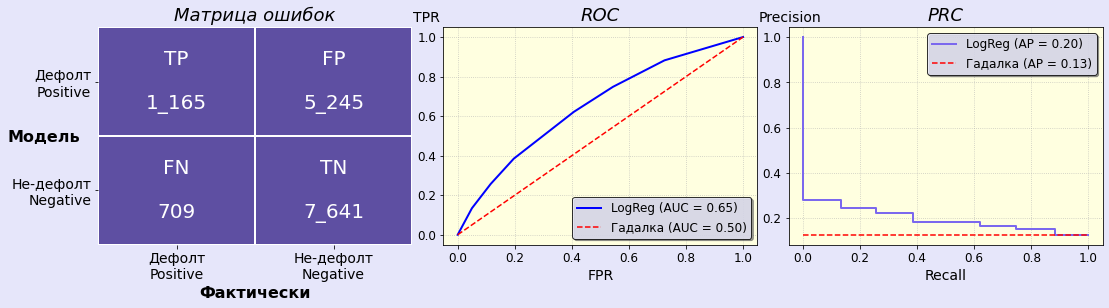

In [153]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default.copy()
X = data[data.flag=='train'][[col]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)

In [154]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
clf_report = classification_report(conf_table[2], conf_table[3], 
                                   digits=3, output_dict=True)
f1_macro = clf_report['macro avg']['f1-score']
mcc = matthews_corrcoef(conf_table[2], conf_table[3])
AUC_ROC = roc_auc_score(conf_table[2], y_pred_proba[:,1])
df_features_rating = df_features_rating.join(df_IV)
df_features_rating.loc['MCC', f'{col}'] = mcc
df_features_rating.loc['f1_macro', f'{col}'] = f1_macro
df_features_rating.loc['AUC', f'{col}'] = AUC_ROC
np.round(df_features_rating, 3)

,education,sex,car,good_work,region_rating,home_address,work_address,sna,first_time,foreign_passport,age,app_date,decline_app_cnt,bki_request_cnt,income,score_bki
IV,0.070,0.003,0.034,0.019,0.081,0.079,0.067,0.132,0.101,0.049,0.009,0.014,0.111,0.052,0.038,0.271
f1_macro,0.378,0.452,0.282,0.257,0.320,0.436,0.401,0.516,0.515,0.256,0.404,0.305,0.561,0.445,0.383,0.500
MCC,0.075,0.028,0.070,0.036,0.078,0.094,0.083,0.120,0.096,0.062,0.021,0.022,0.127,0.062,0.052,0.144
AUC,0.560,0.521,0.541,0.520,0.569,0.570,0.565,0.594,0.586,0.534,0.520,0.524,0.573,0.560,0.552,0.648


Признак `score_bki` обладает наибольшим среди всех признаков значением IV = 0.271. Формально этот признак имеет среднюю прогностическую силу, однако судя по коэффициенту корреляции Мэтьюса, а также по AUC ROC, этот признак обладает максимальной ценностью для нашего проекта в рамках задачи классификации.

Рискну предположить: ценность признака `score_bki` во многом обусловлена тем, что для него смесь классов является наименее однородной - по сравнению с другими признаками. Иначе говоря, у `score_bki` разделимость классов наибольшая.

### 3.18. Полу-наивный байесовский классификатор на WoE-преобразованных признаках.
Итак, соберём всё воедино и посмотрим, как работает классификатор на WoE-преобразованных признаках.

(59039, 16) (14760, 16)
              precision    recall  f1-score   support

   Не-дефолт      0.934     0.669     0.779     12886
      Дефолт      0.229     0.676     0.342      1874

    accuracy                          0.670     14760
   macro avg      0.582     0.672     0.561     14760
weighted avg      0.845     0.670     0.724     14760

Коэффициент Мэтьюса:  0.237


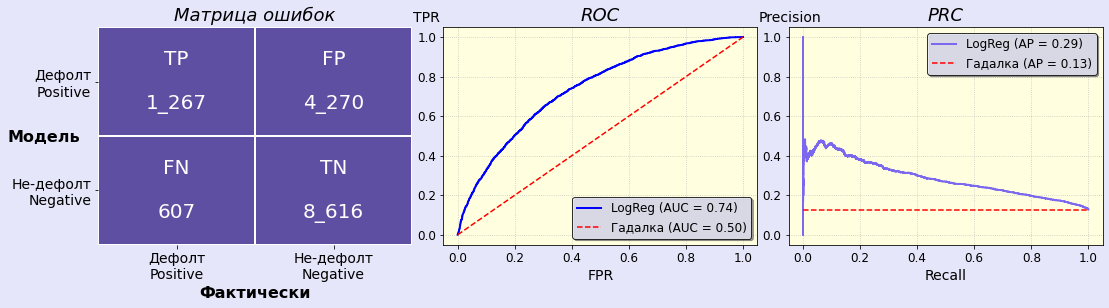

In [155]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default
X = data[data.flag=='train'].drop(columns=['client_id', 'flag', 'default'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)
print(X_train.shape, X_test.shape)
# Логистическая регрессия:
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)
# Запоминаем параметры для сравнения:
conf_table = (lr, X_test, y_test, y_pred)
coef_vals = (lr.coef_[0], X.columns)
# Матрица ошибок, ROC и PRC:
confusion_table_ROC_and_PRC(*conf_table)
# Отчёт по метрикам:
cl_names = ['Не-дефолт', 'Дефолт']
print('='*53)
print(classification_report(conf_table[2], conf_table[3],
                            target_names=cl_names, digits=3)[:-1])
print('='*53)
MCC = matthews_corrcoef(y_test, lr.predict(X_test))
print(f"\nКоэффициент Мэтьюса: {MCC: .3f}")

Посмотрим, как изменятся предсказания модели, если применить различные "улучшайзеры" типа целевого подбора гиперпараметров на улучшение той или иной метрики. Процесс этот "кушает" много машинного времени, поэтому сначала снизим размерность признаковой матрицы.

#### 3.18.1. Устранение коррелирующих признаков.
Собственно, у нас их два: `home_address` и `work_address`. Коэффициент корреляции для них, как видно из Раздела 2, составляет 0.73. Да есть ещё корреляция между `sna` и `firdt_time` на уровне -0.53, но будем считать это малой корреляцией.

Можно было бы сгенерировать новый признак посредством линейной комбинации `home_address` и `work_address`, воспользовавшись методом главных компонентов. Однако у нас есть IV, поэтому из этих двух признаков оставим тот, чье значение IV выше.

In [156]:
np.round(df_features_rating.loc[['IV'], ['home_address', 'work_address']].T, 3)

,IV
home_address,0.079
work_address,0.067


Таким образом, оставляем признак `home_address`.

In [157]:
data = data.drop(columns=['work_address'])
data.to_csv('data_for_WoE.csv', index=False)

In [158]:
print(data.columns.to_list())

['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt', 'region_rating', 'home_address', 'income', 'sna', 'first_time', 'foreign_passport', 'default', 'flag']


#### 3.18.2. Последовательное удаление признаков.
Можно воспользоваться для этого встроенной процедурой sklearn типа RFE, но мы выполним процедуру удаления признаков "ручками", основываясь на величине Inforamtion Value признаков. При этом будем осуществлять контроль на коэффициенте корреляции Мэтьюса (MCC) - в Разделе 2 мы пришли к выводу, что именно эта величина выражает confusion matrix (которая является наиболее удобной "метрикой") в "концентрированном" виде, т.е. в виде одного числа, при вычислении которого учитываются все элементы матрицы ошибок.

Предварительно отыщем такой вес класса "Дефолт", который доставляет наибольшее значение MCC для текущей модели, т.е. повторим процедуру из Раздела 2. Задействуем поиск на сетке.

##### _Отыскание веса класса "Дефолт", который доставляет максимум для MCC._
По мотивам статьи [_"How to Improve Class Imbalance using Class Weights in Machine Learning"._](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

Процедура реализована в отдельном файле *g_search_for_MCC1_max_part_3_18_2.ipynb*, чтобы не "разбухать" текущий блокнот.

,Экстремум
w1,4.630
MCC,0.245


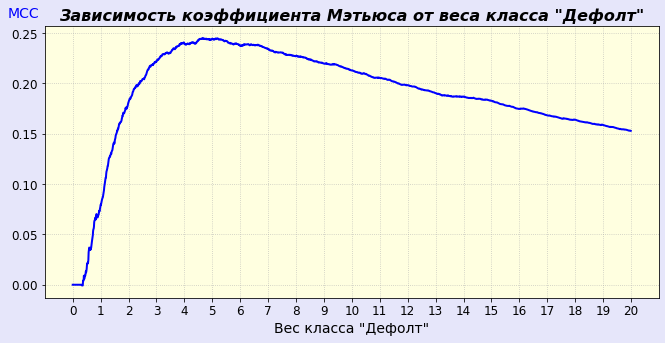

In [159]:
#------------------------------------------------------------------------------#
df_MCC = pd.read_csv('df_MCC1_max_point_3_18_2.csv')
#---
fig, ax = plt.subplots(figsize=(11,5))
plt.plot(df_MCC['w1'], df_MCC['MCC'], lw=2, color='b');
ax.set_title('Зависимость коэффициента Мэтьюса от веса класса "Дефолт"', 
              style='italic', fontweight='bold')
ax.set_xlabel('Вес класса "Дефолт"'); ax.set_xticks(range(21))
ax.set_ylabel('MCC', rotation=0, position=(0, 1.02), ha='left', color='blue')
#---
idx = df_MCC.MCC.idxmax()
df = df_MCC.loc[[idx], ['w1', 'MCC']].T; df.columns = ['Экстремум']
np.round(df, 3)

##### _Удаление "слабых" признаков._

#### Однородная смесь классов в проекте убивает всякий энтузиазм. Можно было бы и дальше улучшать модель подбором гиперпараметров и т.п., но толку это не даст - на фоне равномерной смеси. Сдаю как есть.


In [160]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default
X = data[data.flag=='train'].drop(columns=['client_id', 'flag', 'default'])
X_for_kaggle = data[data.flag=='test'].drop(columns=['client_id', 'flag',
                                                     'default'])
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000,
                        class_weight='balanced')
lr.fit(X, y)
y_for_kaggle = lr.predict_proba(X_for_kaggle)
df = data[data.flag=='test'][['client_id']].copy()
df['default'] = y_for_kaggle[:,1]
df.to_csv('my_submission.csv', index=False)

In [161]:
df


,client_id,default
73799,74835,0.170274
73800,17527,0.754456
73801,75683,0.328969
73802,26883,0.341367
73803,28862,0.123384
...,...,...
110143,83775,0.819645
110144,106254,0.094902
110145,81852,0.768975
110146,1971,0.663026
